In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import argparse
from prophet import Prophet

C:\Users\katka\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\katka\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\katka\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('strings', metavar='STRING', nargs='*', help='String for searching')
parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')
parser.add_argument('--predict_periods', help="How many periods to the future to predict.", type=int, default=365)
parser.add_argument('--data_file', help="File name with dataset.", type=str, default='accidents_daily_temp.csv')

args = parser.parse_args()

periods_to_predict = int(args.predict_periods)
data_file = args.data_file

In [3]:
dataset_df = pd.read_csv(data_file, index_col='date', parse_dates=True)

dataset_df

y  temp
date                 
2016-01-01  450  -0.6
2016-01-02  148  -0.3
2016-01-03   99  -4.4
2016-01-04  344  -5.9
2016-01-05  271  -4.7
...         ...   ...
2022-12-27  169   2.7
2022-12-28  157   3.6
2022-12-29  151   8.1
2022-12-30  157   6.7
2022-12-31  111  12.6

[2557 rows x 2 columns]

In [4]:
# split the data to training set and test set
column_names = ['ds', 'y', 'temp']  # ds = date, y = number of accidents in that day/month

# train set = years 2016-2021, test set = year 2022
dataset_train = dataset_df[:len(dataset_df) - periods_to_predict].reset_index()  # reserve last 12 observation as test set
dataset_train.columns = column_names
dataset_test = dataset_df[len(dataset_df) - periods_to_predict:].reset_index()
dataset_test.columns = column_names

print(dataset_train)
print(dataset_test)

             ds    y  temp
0    2016-01-01  450  -0.6
1    2016-01-02  148  -0.3
2    2016-01-03   99  -4.4
3    2016-01-04  344  -5.9
4    2016-01-05  271  -4.7
...         ...  ...   ...
2187 2021-12-27  214  -2.4
2188 2021-12-28  199  -0.4
2189 2021-12-29  181   3.6
2190 2021-12-30  198   9.1
2191 2021-12-31  141  11.2

[2192 rows x 3 columns]
            ds    y  temp
0   2022-01-01  543   9.7
1   2022-01-02  123   6.7
2   2022-01-03  234   7.8
3   2022-01-04  246   7.7
4   2022-01-05  219   2.8
..         ...  ...   ...
360 2022-12-27  169   2.7
361 2022-12-28  157   3.6
362 2022-12-29  151   8.1
363 2022-12-30  157   6.7
364 2022-12-31  111  12.6

[365 rows x 3 columns]


In [5]:
dataset_df.reset_index(inplace=True)
dataset_df.columns = column_names

print(dataset_df)

             ds    y  temp
0    2016-01-01  450  -0.6
1    2016-01-02  148  -0.3
2    2016-01-03   99  -4.4
3    2016-01-04  344  -5.9
4    2016-01-05  271  -4.7
...         ...  ...   ...
2552 2022-12-27  169   2.7
2553 2022-12-28  157   3.6
2554 2022-12-29  151   8.1
2555 2022-12-30  157   6.7
2556 2022-12-31  111  12.6

[2557 rows x 3 columns]


In [6]:
# create a dataframe that will contain forecasts from all applied algorithms
predict_df = pd.DataFrame(dataset_df['ds'])

# add new dates to the predict_df in the length of months from the arguments
last_date = dataset_df['ds'].max()
next_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(next_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

predict_df = pd.concat([predict_df, new_rows])

# add original values to the predict_df dataframe
predict_df['original'] = list(dataset_train['y']) + list(dataset_test['y']) + [None] * periods_to_predict
predict_df['temp'] = list(dataset_train['temp']) + list(dataset_test['temp']) + [None] * periods_to_predict
predict_df.set_index('ds', inplace=True)

predict_df['temp'] = predict_df['temp'].fillna(10)
predict_df

original  temp
ds                        
2016-01-01     450.0  -0.6
2016-01-02     148.0  -0.3
2016-01-03      99.0  -4.4
2016-01-04     344.0  -5.9
2016-01-05     271.0  -4.7
...              ...   ...
2023-12-27       NaN  10.0
2023-12-28       NaN  10.0
2023-12-29       NaN  10.0
2023-12-30       NaN  10.0
2023-12-31       NaN  10.0

[2922 rows x 2 columns]

In [7]:
# Prophet

prophet_model = Prophet()  # create new object for forecasting
prophet_model.add_regressor('temp', standardize=False)  # include temperature in the model
prophet_model.fit(dataset_train)  # fit the training data
#future = prophet_model.make_future_dataframe(periods=periods_to_predict + periods_to_predict, freq='1d')  # set length of forecast

prophet_future_df = predict_df.reset_index().tail(periods_to_predict + periods_to_predict)[['ds', 'temp']]

forecast = prophet_model.predict(prophet_future_df)  # predict for the number of observations set as a command-line argument

00:06:29 - cmdstanpy - INFO - Chain [1] start processing
00:06:32 - cmdstanpy - INFO - Chain [1] done processing


Text(83.09722222222221, 0.5, 'number of accidents')

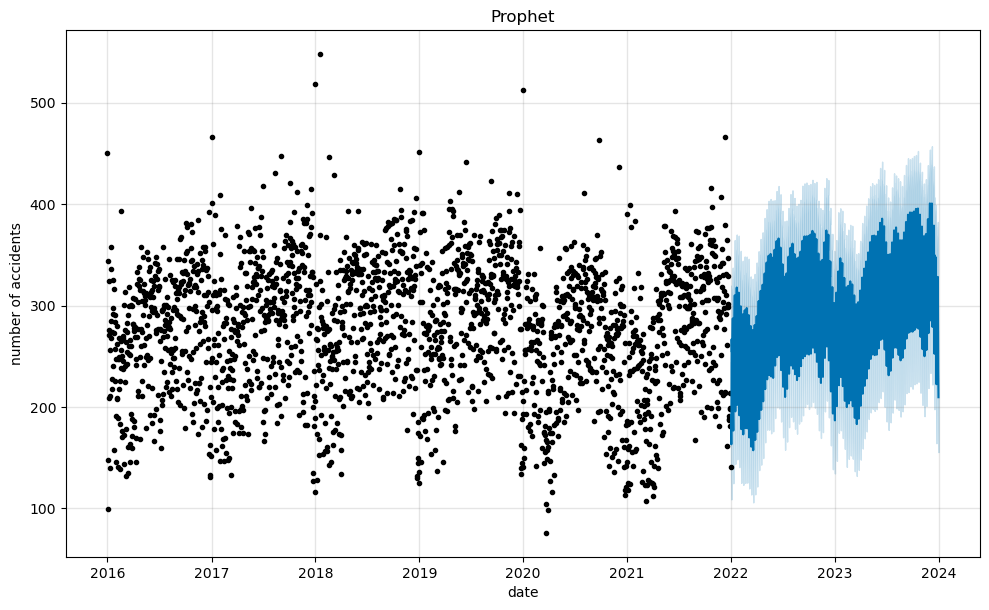

In [8]:
fig1 = prophet_model.plot(forecast)  # plot the forecast
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

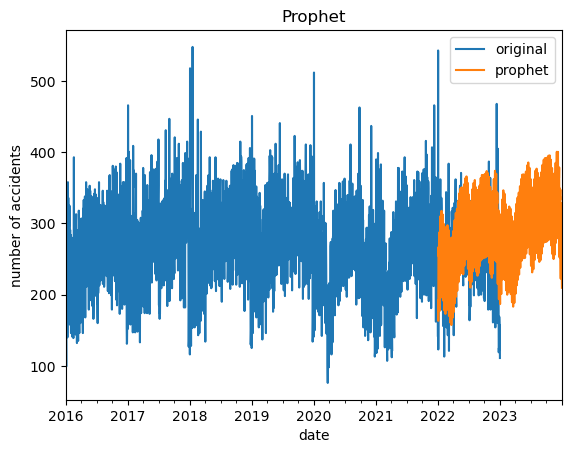

In [9]:
predict_df['prophet'] = [None]*len(dataset_train) + list(forecast['yhat'].tail(periods_to_predict + periods_to_predict))  # add the forecast to predict_df

predict_df[['original', 'prophet']].plot()
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [10]:
prophet_model.params

OrderedDict([('lp__', array([[4578.68]])),
             ('k', array([[0.0854409]])),
             ('m', array([[0.483901]])),
             ('delta',
              array([[ 8.40557e-08,  3.35985e-08, -1.55718e-08,  1.62900e-07,
                      -6.21398e-08, -2.53261e-08,  2.56317e-08, -6.39173e-07,
                      -2.58289e-07, -3.96179e-03, -1.89568e-07, -4.97259e-07,
                      -6.33271e-08, -4.02484e-08, -4.27858e-08, -1.38216e-07,
                      -2.31501e-01, -1.49368e-01, -9.82796e-03, -3.92596e-07,
                      -5.00135e-08,  2.67661e-05,  4.75199e-08,  8.09854e-08,
                       5.62810e-01]])),
             ('sigma_obs', array([[0.074455]])),
             ('beta',
              array([[-0.0392401 , -0.0214072 , -0.0243213 ,  0.00116554,  0.0148318 ,
                       0.00387533, -0.00086484, -0.00887523, -0.00506351, -0.0077441 ,
                      -0.00488326, -0.0137472 ,  0.00789228, -0.00498445,  0.00228971,
           

In [14]:
from scalecast.Forecaster import Forecaster

In [15]:
# create a Forecaster object that will make forecasts from multiple models
f_model = Forecaster(
    y=np.array(dataset_df.reset_index()['y']),
    current_dates=np.array(dataset_df.reset_index()['ds'])
)
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [16]:
f_model.set_test_length(periods_to_predict)  # reserve last n observations as a test set
f_model.generate_future_dates(periods_to_predict)  # predict 12 months into the future
f_model.set_validation_length(f_model.test_length)
f_model.auto_Xvar_select()  # automatic selection of the most optimal regressors
f_model.add_series(predict_df['temp'], called='temp')  # add regressor with temperatures
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=365
    Xvars=['temp', 'lnt', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53']
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [17]:
forecaster_estimators = ['arima', 'svr', 'xgboost', 'catboost', 'rnn', 'lstm']  # models that will by predicted by Forecaster
for estimator in forecaster_estimators:
    f_model.set_estimator(estimator)
    f_model.tune()  # find optimal hyperparameters for the current model
    f_model.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {estimator}:')
    print(f_model.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 1, 1, 7)}
Hyperparameter values for svr:
{'kernel': 'linear', 'C': 3, 'epsilon': 0.01, 'gamma': 'scale'}
Hyperparameter values for xgboost:
{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}
Hyperparameter values for catboost:
{'iterations': 300, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 5, 'verbose': 0}
67/67 [==============================] - 2s 30ms/step
Hyperparameter values for rnn:
{'layers_struct': [('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': False})], 'epochs': 25, 'verbose': 0}
69/69 [==============================] - 1s 8ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'dropout': (0, 0, 0), 'lags': 10, 'verbose': 0, 'epochs': 5}


Text(0, 0.5, 'number of accidents')

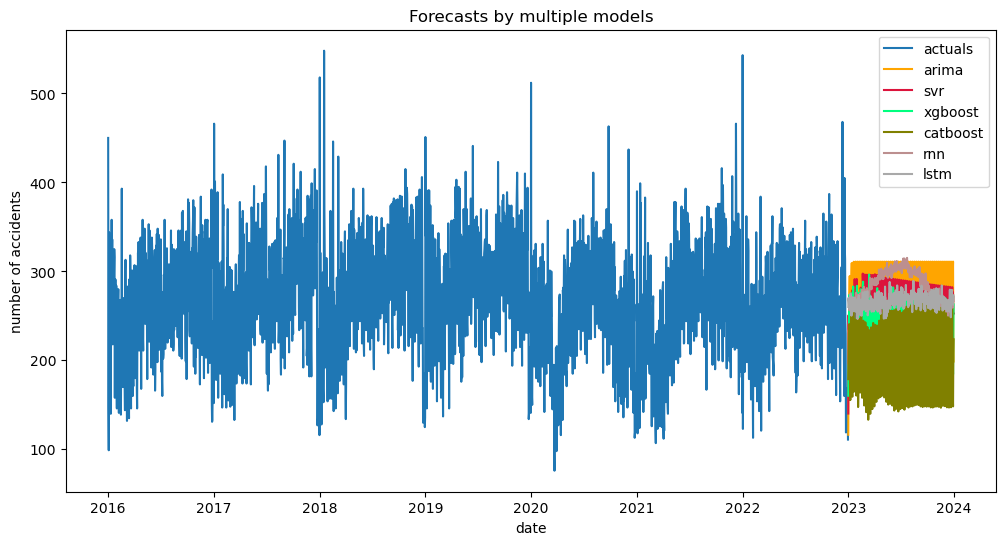

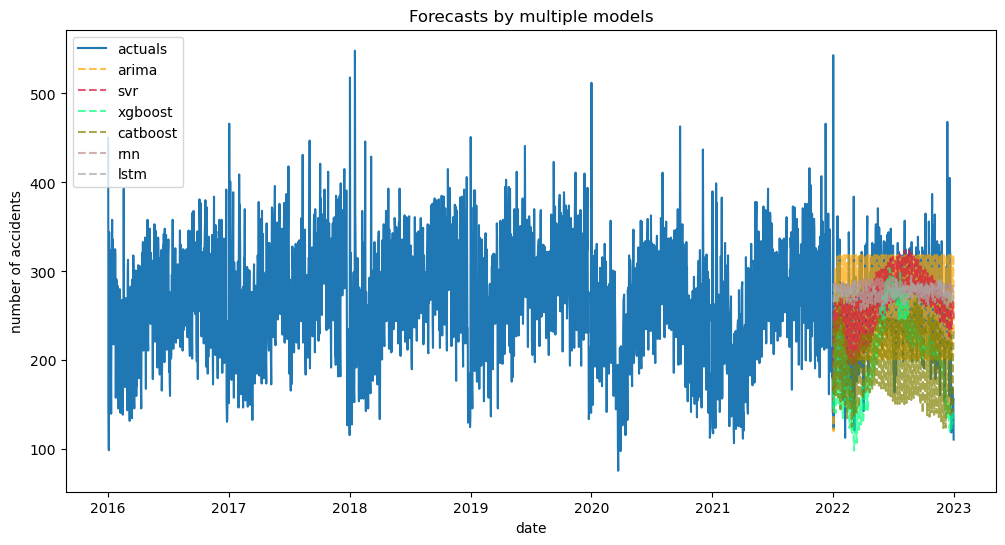

In [18]:
f_model.plot()  # plots future values
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")
f_model.plot_test_set()  # plots values from test set
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [19]:
# add forecasts from models in Forecaster to predict_df
for method in forecaster_estimators:
    result = f_model.export_fitted_vals(method)
    predict_df[method] = [None] * len(dataset_train) + list(result.tail(periods_to_predict + periods_to_predict)['FittedVals'])

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.metrics import accuracy_score

In [21]:
# split datetime to day, month, and year parts for models with GA
dataset_ga = dataset_df
dataset_ga['day'] = dataset_df['ds'].dt.day
dataset_ga['month'] = dataset_df['ds'].dt.month
dataset_ga['year'] = dataset_df['ds'].dt.year
dataset_ga['temp'] = dataset_df['temp']
dataset_ga

ds    y  temp  day  month  year
0    2016-01-01  450  -0.6    1      1  2016
1    2016-01-02  148  -0.3    2      1  2016
2    2016-01-03   99  -4.4    3      1  2016
3    2016-01-04  344  -5.9    4      1  2016
4    2016-01-05  271  -4.7    5      1  2016
...         ...  ...   ...  ...    ...   ...
2552 2022-12-27  169   2.7   27     12  2022
2553 2022-12-28  157   3.6   28     12  2022
2554 2022-12-29  151   8.1   29     12  2022
2555 2022-12-30  157   6.7   30     12  2022
2556 2022-12-31  111  12.6   31     12  2022

[2557 rows x 6 columns]

In [22]:
# split data to training and testing sets
X = dataset_ga[['day', 'month', 'year', 'temp']]
y = dataset_ga['y']
X_train_ga = X[:len(X) - periods_to_predict]
X_test_ga = X[len(X) - periods_to_predict:]
y_train_ga = y[:len(y) - periods_to_predict]  # test set = observations from the last year
y_test_ga = y[len(y) - periods_to_predict:]
X_train_ga.shape, X_test_ga.shape, y_train_ga.shape, y_test_ga.shape

((2192, 4), (365, 4), (2192,), (365,))

In [23]:
rf = RandomForestRegressor(random_state=111)

In [24]:
# adapters used in GA Search
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [25]:
# grid with attributes for random forest, for genetic algorithm
rf_grid_ga = {
    'n_estimators': Integer(100, 600),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'max_depth': Integer(2,20),
    'criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'min_samples_split': Continuous(0.1, 0.9),
    'bootstrap': Categorical([True, False])
}

In [26]:
rf_estimator_ga = GASearchCV(estimator=rf,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [27]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)  # fit the training data

gen	nevals	fitness   	fitness_std	fitness_max	fitness_min
0  	100   	-0.0937707	0.228413   	0.00355186 	-1.59857   
1  	200   	-0.0139536	0.0173614  	0.00355186 	-0.0685741 
2  	200   	-0.00260364	0.005578   	0.00355186 	-0.0216967 
3  	200   	0.000509314	0.0028303  	0.00406597 	-0.0107008 
4  	200   	0.00204632 	0.00283944 	0.00428205 	-0.0190581 
5  	200   	0.00292904 	0.0015538  	0.00455002 	-0.0078887 
6  	200   	0.00325786 	0.00173903 	0.00455002 	-0.0128594 
7  	200   	0.00341616 	0.00271443 	0.00455002 	-0.0228659 
8  	200   	0.00394176 	0.000694036	0.0046037  	-0.000777402
9  	200   	0.00355152 	0.00668424 	0.00501414 	-0.0626592  
10 	200   	0.00444635 	0.000254033	0.00501414 	0.00339815  
11 	200   	0.00448745 	0.000523445	0.00501414 	-0.0005504  
12 	200   	0.00456859 	9.09481e-05	0.00501414 	0.00455002  


C:\Users\katka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001C6BD674610>,
           error_score='raise',
           estimator=RandomForestRegressor(criterion='poisson', max_depth=2,
                                           max_features='auto',
                                           min_samples_split=0.21607935965276914,
                                           n_estimators=273, random_state=111),
           generations=12,
           mutation_probability=<sklearn_genetic.sch...
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x000001C6BFBAA190>,
                       'max_features': <sklearn_genetic.space.space.Categorical object at 0x000001C6BFBAA7C0>,
                       'min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x000001C6BFBAA1F0>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x000001C6BFBAA9A0>},
           population_size=100, return_train_score=True, scoring='r2')

In [28]:
rf_estimator_ga.best_params_

{'n_estimators': 273,
 'max_features': 'auto',
 'max_depth': 2,
 'criterion': 'poisson',
 'min_samples_split': 0.21607935965276914,
 'bootstrap': True}

In [29]:
# prepare testing data with future dates in the length of argument months_to_predict
last_date = dataset_ga.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
new_rows['temp'] = [10] * len(new_rows)
X_test_ga = pd.concat([X_test_ga, new_rows])

In [30]:
X_test_ga = X_test_ga[['day', 'month', 'year', 'temp']]
X_test_ga

day  month  year  temp
2192    1      1  2022   9.7
2193    2      1  2022   6.7
2194    3      1  2022   7.8
2195    4      1  2022   7.7
2196    5      1  2022   2.8
...   ...    ...   ...   ...
361    27     12  2023  10.0
362    28     12  2023  10.0
363    29     12  2023  10.0
364    30     12  2023  10.0
365    31     12  2023  10.0

[730 rows x 4 columns]

In [31]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)  # predict future dates

In [32]:
y_predict_rf_ga

array([251.75608134, 249.96626014, 250.25042179, 250.25042179,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.84817689, 249.84817689, 249.84817689, 249.84817689,
       249.84817689, 249.84817689, 249.84817689, 250.6724346 ,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 250.25042179,
       249.96626014, 249.96626014, 249.96626014, 249.96626014,
       249.96626014, 249.96626014, 249.96626014, 249.84817689,
       249.84817689, 249.84817689, 249.84817689, 250.6724346 ,
       249.96626014, 249.96626014, 249.96626014, 249.96

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

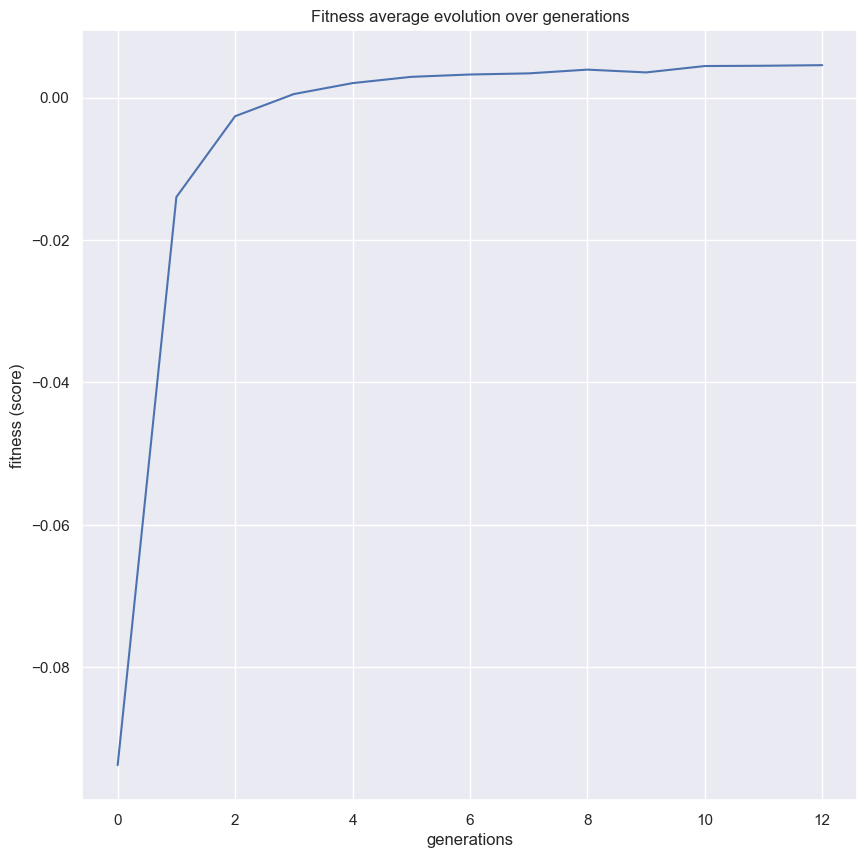

In [33]:
plot_fitness_evolution(rf_estimator_ga)

In [34]:
# prepare dataframe with forecast values (predict_df will contain all hyperparameter optimization techniques)
rf_predict_df = dataset_df[['ds']]

last_date = rf_predict_df.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

rf_predict_df = pd.concat([rf_predict_df, new_rows])

rf_predict_df['original'] = list(y_train_ga) + list(y_test_ga) + [None] * periods_to_predict
rf_predict_df['predicted - GA'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)
rf_predict_df.set_index('ds', inplace=True)

Text(0, 0.5, 'number of accidents')

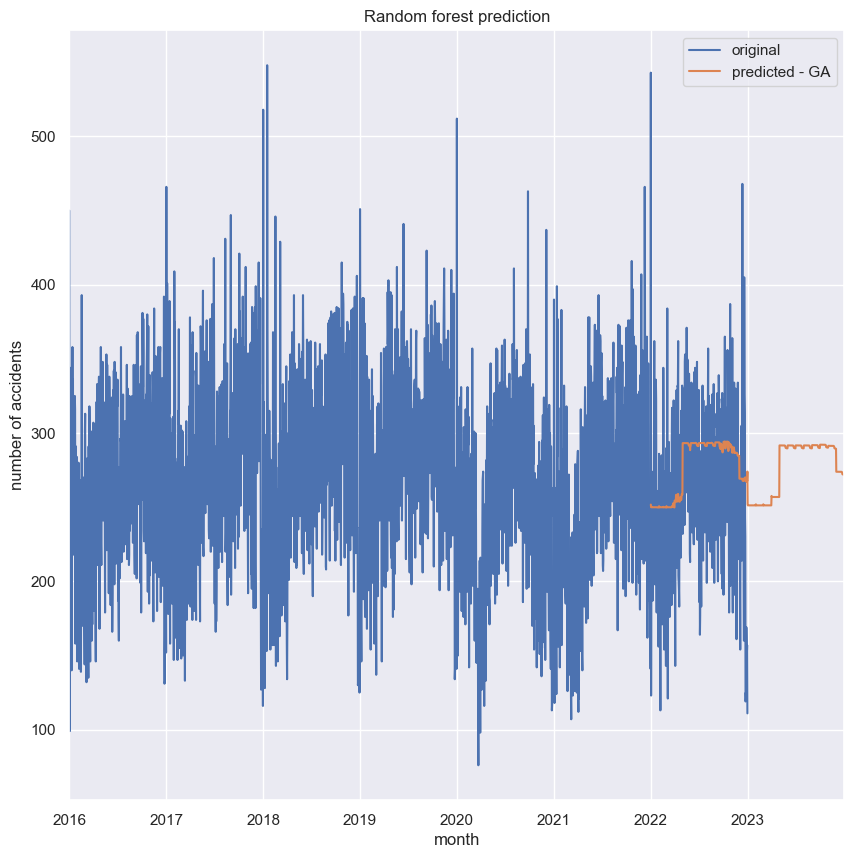

In [35]:
# plot results with random forest and GA
rf_predict_df.plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [36]:
# create grid for randomized searach cv
rf_grid_randomized = {
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.9],
    'bootstrap': [True, False]
}

In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
rf = RandomForestRegressor(random_state=111)
rf_estimator_randomized = RandomizedSearchCV(estimator=rf,
                                             scoring='r2',
                                             param_distributions = rf_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [39]:
rf_estimator_randomized.fit(X_train_ga, y_train_ga)

RandomizedSearchCV(error_score='raise',
                   estimator=RandomForestRegressor(random_state=111), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['poisson',
                                                      'squared_error',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [2, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [0.1, 0.9],
                                        'n_estimators': [100, 600]},
                   random_state=111, scoring='r2')

In [40]:
rf_estimator_randomized.best_params_

{'n_estimators': 100,
 'min_samples_split': 0.1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'absolute_error',
 'bootstrap': False}

In [41]:
y_predict_rf_randomized = rf_estimator_randomized.predict(X_test_ga)

In [42]:
rf_predict_df['predicted - randomized'] = [None] * len(X_train_ga) + list(y_predict_rf_randomized)

Text(0, 0.5, 'number of accidents')

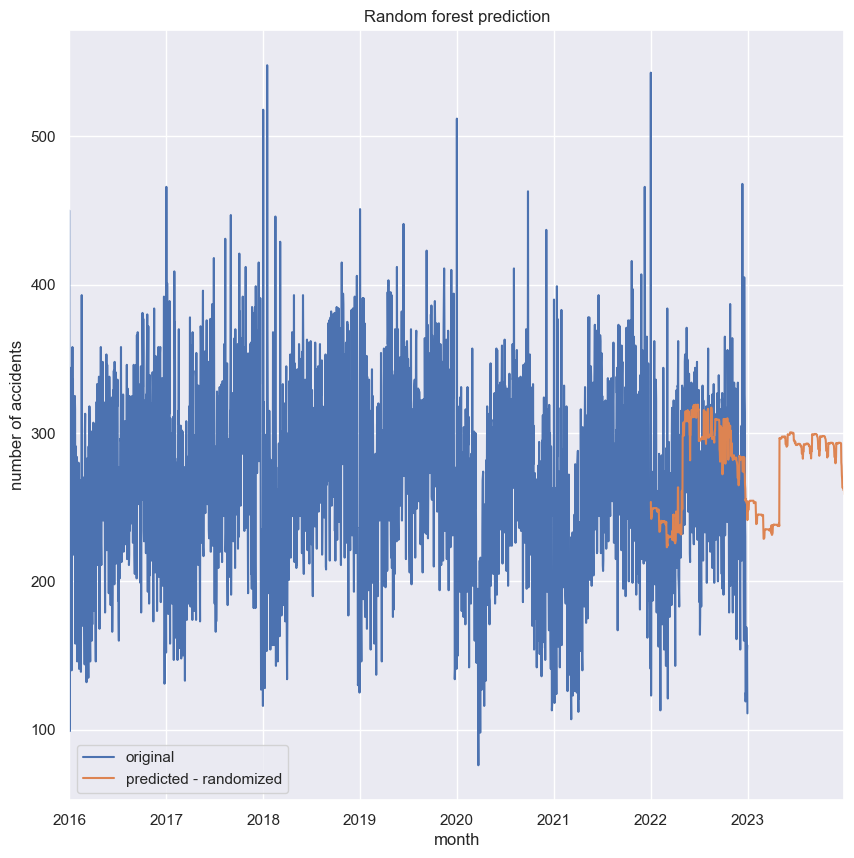

In [43]:
# plot results with random forest and randomized search cv
rf_predict_df[['original', 'predicted - randomized']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [44]:
# grid for grid search cv
rf_grid_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 10, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.5, 0.9],
    'bootstrap': [True, False]
}

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
from sklearn.model_selection import GridSearchCV
rf_estimator_grid = GridSearchCV(estimator=rf,
                                 scoring='r2',
                                 param_grid = rf_grid_grid,
                                 n_jobs=-1,
                                 error_score='raise'
                                )

In [47]:
y_predict_rf_grid = rf_estimator_grid.fit(X_train_ga, y_train_ga)

In [48]:
rf_estimator_grid.best_params_

{'bootstrap': False,
 'criterion': 'poisson',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 0.1,
 'n_estimators': 200}

In [49]:
y_predict_rf_grid = rf_estimator_grid.predict(X_test_ga)

In [50]:
y_predict_rf_grid

array([265.69384055, 238.84435775, 238.96495924, 238.96495924,
       238.98705044, 241.42381584, 241.42381584, 242.54129905,
       239.67914418, 240.20604791, 242.54129905, 242.54129905,
       239.67914418, 240.20604791, 240.13372014, 242.54129905,
       240.48246489, 239.67914418, 240.13372014, 240.13372014,
       242.54129905, 240.13372014, 240.27121268, 240.44838545,
       240.44838545, 240.44838545, 240.44838545, 240.44838545,
       240.73921088, 241.12438346, 240.73921088, 260.91276239,
       234.13173367, 234.13173367, 234.23213404, 234.27442636,
       234.91826525, 234.68881345, 234.56541866, 234.78072821,
       234.78072821, 234.68032785, 234.3315831 , 234.3315831 ,
       234.68032785, 234.60800008, 234.70840044, 234.85372978,
       234.64067482, 234.64067482, 234.64067482, 234.64067482,
       234.76972625, 234.42942262, 235.43490135, 234.82666977,
       234.82666977, 234.82666977, 235.74433184, 255.05296308,
       226.56890681, 226.56890681, 226.91149582, 226.56

In [51]:
rf_predict_df['predicted - grid'] = [None] * len(X_train_ga) + list(y_predict_rf_grid)

Text(0, 0.5, 'number of accidents')

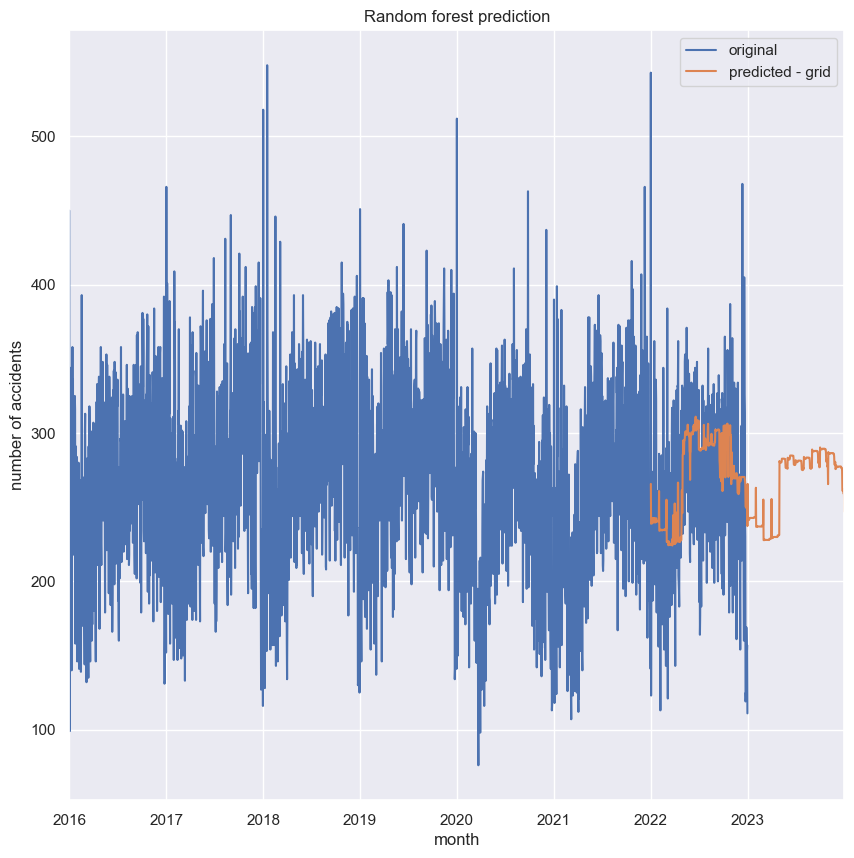

In [52]:
# plot results with random forest and grid search cv
rf_predict_df[['original', 'predicted - grid']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [53]:
# r2 score with GA search cv
rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

0.05223626021061889

In [54]:
# r2 score with randomized search cv
rf_estimator_randomized.score(X_test_ga[:periods_to_predict], y_test_ga)

0.0492908547376375

In [55]:
# r2 score with grid search cv
rf_estimator_grid.score(X_test_ga[:periods_to_predict], y_test_ga)

0.08843554424787392

Text(0, 0.5, 'number of accidents')

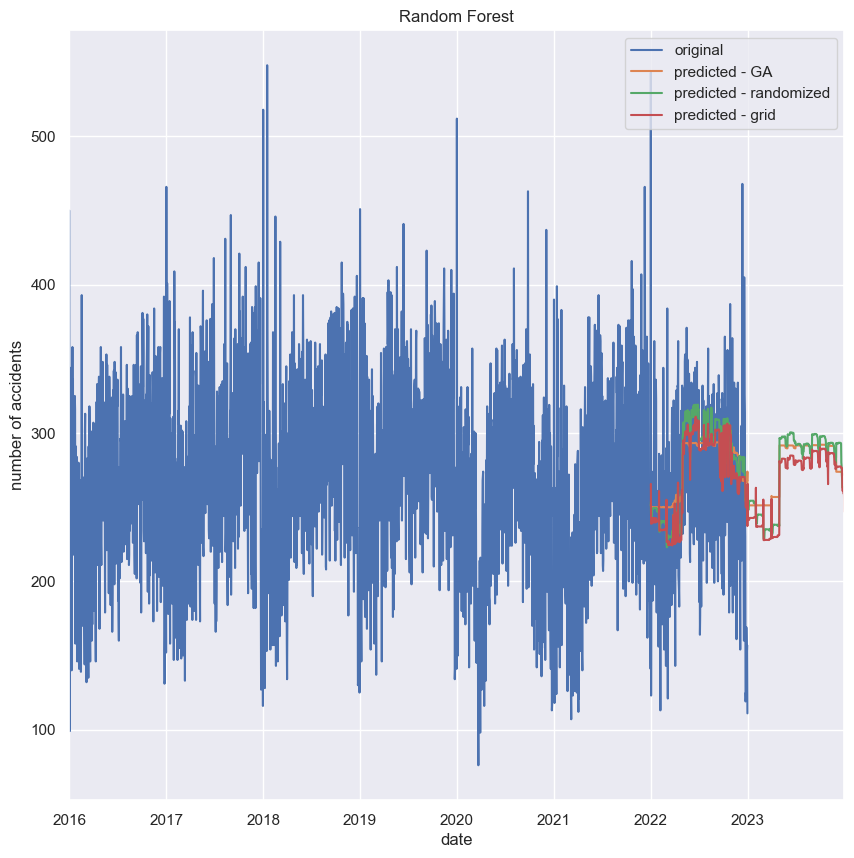

In [56]:
# plot all 3 techniques for random forest on one plot
rf_predict_df.plot()
plt.title("Random Forest")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [57]:
predict_df['random forest + GA'] = list(rf_predict_df['predicted - GA'])
predict_df['random forest + randomized'] = list(rf_predict_df['predicted - randomized'])
predict_df['random forest + grid'] = list(rf_predict_df['predicted - grid'])

predict_df

original  temp     prophet       arima         svr     xgboost  \
ds                                                                           
2016-01-01     450.0  -0.6         NaN         NaN         NaN         NaN   
2016-01-02     148.0  -0.3         NaN         NaN         NaN         NaN   
2016-01-03      99.0  -4.4         NaN         NaN         NaN         NaN   
2016-01-04     344.0  -5.9         NaN         NaN         NaN         NaN   
2016-01-05     271.0  -4.7         NaN         NaN         NaN         NaN   
...              ...   ...         ...         ...         ...         ...   
2023-12-27       NaN  10.0  313.486752  201.620252  248.666615  168.264496   
2023-12-28       NaN  10.0  310.874906  204.317466  234.969947  151.167664   
2023-12-29       NaN  10.0  328.197688  217.440162  226.118038  154.053253   
2023-12-30       NaN  10.0  237.712232  225.309309  240.963728  153.283981   
2023-12-31       NaN  10.0  209.610036  136.078315  153.172227  115.143616   

              catboost         rnn        lstm  random forest + GA  \
ds                                                                   
2016-01-01         NaN         NaN         NaN                 NaN   
2016-01-02         NaN         NaN         NaN                 NaN   
2016-01-03         NaN         NaN         NaN                 NaN   
2016-01-04         NaN         NaN         NaN                 NaN   
2016-01-05         NaN         NaN         NaN                 NaN   
...                ...         ...         ...                 ...   
2023-12-27  170.111394  288.600009  276.970255          272.038997   
2023-12-28  165.140365  287.503257  269.905862          271.947476   
2023-12-29  157.369136  293.942132  269.660342          271.947476   
2023-12-30  151.179452  285.632991  275.377497          271.947476   
2023-12-31  123.111052  284.703534  280.473256          271.947476   

            random forest + randomized  random forest + grid  
ds                                                            
2016-01-01                         NaN                   NaN  
2016-01-02                         NaN                   NaN  
2016-01-03                         NaN                   NaN  
2016-01-04                         NaN                   NaN  
2016-01-05                         NaN                   NaN  
...                                ...                   ...  
2023-12-27                     263.605            262.122698  
2023-12-28                     261.560            259.269975  
2023-12-29                     261.560            259.269975  
2023-12-30                     261.560            259.269975  
2023-12-31                     258.785            247.097244  

[2922 rows x 12 columns]

In [58]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler

In [59]:
# # pipeline with data scaling and random forest
# steps = [
#     ('scaler', MinMaxScaler()),  # Data preprocessing step
#     ('rf', RandomForestRegressor(random_state=111))  # Random Forest Regressor step
# ]

In [60]:
# pipeline = Pipeline(steps)

In [61]:
# # GA search cv with pipeline
# rf_grid_ga = {
#     'rf__n_estimators': Integer(100, 600),
#     'rf__max_features': Categorical(['auto', 'sqrt', 'log2']),
#     'rf__max_depth': Integer(2,20),
#     'rf__criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
#     'rf__min_samples_split': Continuous(0.1, 0.9),
#     'rf__bootstrap': Categorical([True, False])
# }

# rf_estimator_ga = GASearchCV(estimator=pipeline,
#                              scoring='r2',
#                              population_size=100,
#                              generations=12,
#                              mutation_probability=mutation_adapter,
#                              crossover_probability=crossover_adapter,
#                              param_grid=rf_grid_ga,
#                              n_jobs=-1,
#                              error_score='raise'
#                             )

In [62]:
# rf_estimator_ga.fit(X_train_ga, y_train_ga)

In [63]:
# y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)

In [64]:
# y_predict_rf_ga

In [65]:
# # r2 score for random forest with GA and pipeline
# rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

In [66]:
# rf_predict_df['predicted - GA - pipe'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)

In [67]:
# # plot results of random forest regressor with pipeline and GA search cv
# rf_predict_df[['original', 'predicted - GA - pipe']].plot()
# plt.title("Random forest prediction")
# plt.xlabel("month")
# plt.ylabel("number of accidents")

In [68]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

In [69]:
mlp = MLPRegressor(random_state=111)

In [70]:
# adapters for MLP with GA search cv
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [71]:
# prepare data for MLP
scaler = StandardScaler()
scaler.fit(dataset_ga[['day', 'month', 'year', 'y', 'temp']].head(len(dataset_ga) - periods_to_predict))  # fit the scaler with training data

# generate new dates
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
new_rows['temp'] = [10] * len(new_rows)
scaled_data = dataset_df[['day', 'month', 'year', 'y', 'temp']]
scaled_data = pd.concat([scaled_data, new_rows[['day', 'month', 'year', 'temp']]])
scaled_data = pd.DataFrame(scaler.transform(scaled_data[['day', 'month', 'year', 'y', 'temp']]), columns=['day', 'month', 'year', 'y', 'temp'])

X = scaled_data[['day', 'month', 'year', 'temp']]
y = scaled_data['y']

# split the scaled data to train and test set
X_train_scale = X.head(len(X) - periods_to_predict - periods_to_predict)
X_test_scale = X.tail(periods_to_predict + periods_to_predict)
y_train_scale = y.head(len(X) - periods_to_predict - periods_to_predict)
y_test_scale = y.tail(periods_to_predict + periods_to_predict)
X_train_scale.shape, X_test_scale.shape, y_train_scale.shape, y_test_scale.shape

((2192, 4), (730, 4), (2192,), (730,))

In [72]:
# hyperparameters in MLP model with GA
mlp_grid_ga = {
    "hidden_layer_sizes": Integer(5, 200), 
    "activation": Categorical(["identity", "logistic", "tanh", "relu"]), 
    "solver": Categorical(["lbfgs", "sgd", "adam"]), 
    "alpha": Continuous(0.00005, 0.05),
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "max_iter": Integer(150, 300)
}

In [73]:
mlp_estimator_ga = GASearchCV(estimator=mlp,
                             scoring='r2',
                             population_size=200,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=mlp_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [74]:
mlp_estimator_ga.fit(X_train_scale, y_train_scale)

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	200   	-0.352574	0.534881   	0.015175   	-3.04009   
1  	400   	-0.0991074	0.0888034  	0.0254382  	-1.03739   
2  	400   	-0.0557304	0.0403154  	0.0254382  	-0.13687   
3  	400   	-0.0313757	0.0318323  	0.0254381  	-0.124674  
4  	400   	-0.012749 	0.0274632  	0.0254381  	-0.0990049 
5  	400   	-0.000513522	0.0249898  	0.0254381  	-0.127241  
6  	400   	0.0129512   	0.00953845 	0.0254382  	-0.0529943 
7  	400   	0.0158348   	0.00933998 	0.0254382  	-0.0978785 
8  	400   	0.0177745   	0.00577228 	0.0254382  	-0.0176683 
9  	400   	0.0202432   	0.00800728 	0.0254382  	-0.0602275 
10 	400   	0.0232924   	0.00416482 	0.0254382  	0.0121179  
11 	400   	0.0249611   	0.00220716 	0.0254382  	0.0121186  
12 	400   	0.0254382   	8.31876e-09	0.0254382  	0.0254381  


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001C6A1878CD0>,
           error_score='raise',
           estimator=MLPRegressor(alpha=0.0010474603795907434,
                                  hidden_layer_sizes=156,
                                  learning_rate='invscaling', max_iter=162,
                                  random_state=111, solver='sgd'),
           generations=12,
           mutation_probability=<sklearn_genetic.schedules.sched...
                       'hidden_layer_sizes': <sklearn_genetic.space.space.Integer object at 0x000001C6C0C4AFD0>,
                       'learning_rate': <sklearn_genetic.space.space.Categorical object at 0x000001C6C0C4A520>,
                       'max_iter': <sklearn_genetic.space.space.Integer object at 0x000001C6C0C4AF10>,
                       'solver': <sklearn_genetic.space.space.Categorical object at 0x000001C6C0C4A4F0>},
           population_size=200, return_train_score=True, scoring='r2')

In [75]:
mlp_estimator_ga.best_params_

{'hidden_layer_sizes': 156,
 'activation': 'relu',
 'solver': 'sgd',
 'alpha': 0.0010474603795907434,
 'learning_rate': 'invscaling',
 'max_iter': 162}

In [76]:
y_predict_mlp_ga = mlp_estimator_ga.predict(X_test_scale)
y_predict_mlp_ga

array([-0.29482001, -0.28946504, -0.31830597, -0.3394417 , -0.31615838,
       -0.32261494, -0.33574408, -0.35365298, -0.37466083, -0.40508689,
       -0.40564668, -0.42912207, -0.46729687, -0.50201772, -0.52112204,
       -0.53778494, -0.56199709, -0.58497275, -0.60378805, -0.62841394,
       -0.67576878, -0.65933504, -0.66097089, -0.66974023, -0.68774844,
       -0.71078912, -0.72314406, -0.71194992, -0.71694641, -0.7136145 ,
       -0.75823836, -0.21054949, -0.23619392, -0.25126903, -0.27271283,
       -0.27861246, -0.29953249, -0.30641652, -0.33326443, -0.38052095,
       -0.4051443 , -0.39547062, -0.3976066 , -0.42752237, -0.45133035,
       -0.48212619, -0.50463628, -0.50789899, -0.52992737, -0.54990335,
       -0.55891163, -0.56422393, -0.59420996, -0.58989776, -0.61059536,
       -0.64082411, -0.66175538, -0.68238301, -0.72368541, -0.15818452,
       -0.18369833, -0.20337501, -0.21857066, -0.23914641, -0.25583405,
       -0.27299561, -0.29027519, -0.30678353, -0.32309846, -0.34

In [77]:
# r2 score for MLP with GA
mlp_estimator_ga.score(X_test_scale.head(periods_to_predict), y_test_scale.head(periods_to_predict))

-0.014623926303183543

In [78]:
# create dataframe with forecast (MLP + GA)
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_ga.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y', 'temp'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_8728\1264332695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_ga.tolist()


day  month    year           y      temp
0     1.0    1.0  2022.0  278.002395  7.334114
1     2.0    1.0  2022.0  253.829874  7.376849
2     3.0    1.0  2022.0  262.693132  7.146686
3     4.0    1.0  2022.0  261.887381  6.978013
4     5.0    1.0  2022.0  222.405597  7.163824
..    ...    ...     ...         ...       ...
725  27.0   12.0  2023.0  280.419647  7.790531
726  28.0   12.0  2023.0  280.419647  7.622784
727  29.0   12.0  2023.0  280.419647  7.457364
728  30.0   12.0  2023.0  280.419647  7.315209
729  31.0   12.0  2023.0  280.419647  7.192319

[730 rows x 5 columns]

Text(0, 0.5, 'number of accidents')

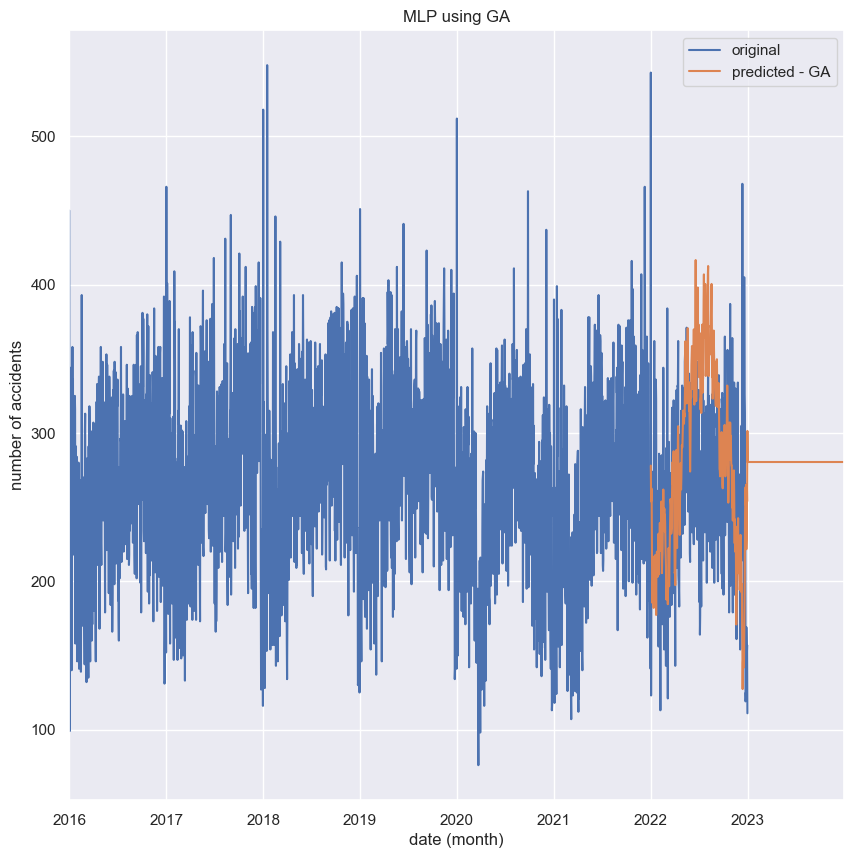

In [79]:
mlp_predict_df = pd.concat([dataset_df[['ds']], new_rows[['ds']]], ignore_index=True)  # add results to predict_df

mlp_predict_df['original'] = list(dataset_df['y']) + [None] * periods_to_predict
mlp_predict_df['predicted - GA'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df.set_index('ds', inplace=True)
mlp_predict_df.plot()  # plot results of MLP with GA
plt.title("MLP using GA")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

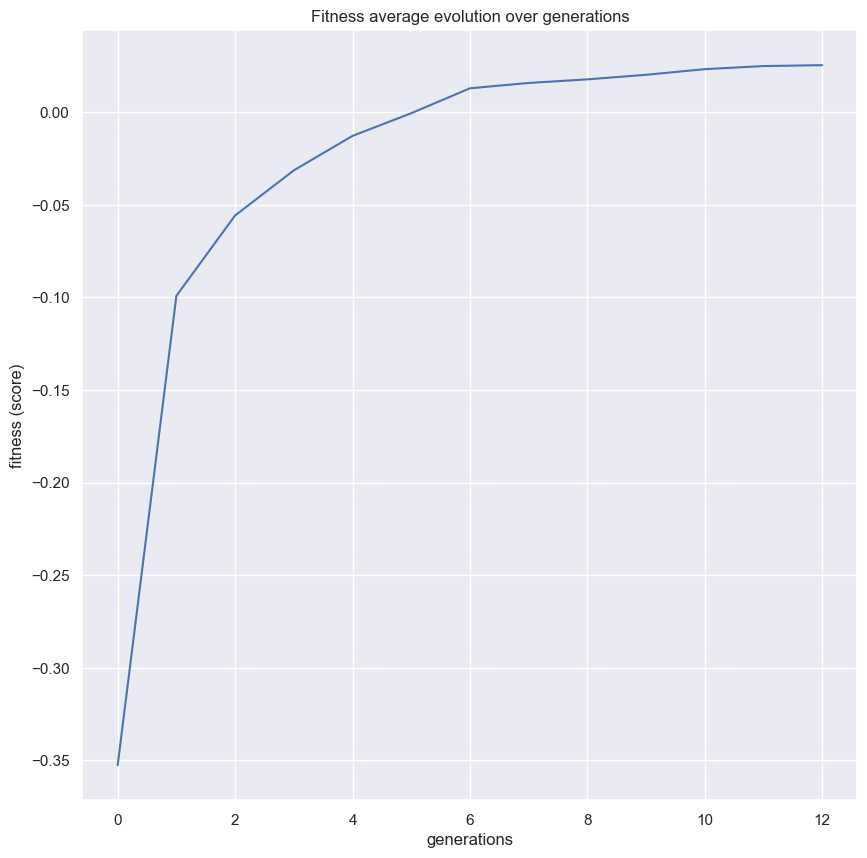

In [80]:
plot_fitness_evolution(mlp_estimator_ga)

In [81]:
# grid for MLP and Randomized search CV
mlp_grid_randomized = {
    "hidden_layer_sizes": [10, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}


In [82]:
from sklearn.model_selection import RandomizedSearchCV

In [83]:
mlp_estimator_randomized = RandomizedSearchCV(estimator=mlp,
                                             scoring='neg_root_mean_squared_error',
                                             param_distributions = mlp_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [84]:
mlp_estimator_randomized.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(error_score='raise',
                   estimator=MLPRegressor(alpha=0.0010474603795907434,
                                          hidden_layer_sizes=156,
                                          learning_rate='invscaling',
                                          max_iter=162, random_state=111,
                                          solver='sgd'),
                   n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [5e-05, 0.05],
                                        'hidden_layer_sizes': [10, 500],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [150, 300],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=111, scoring='neg_root_mean_squared_error')

In [85]:
mlp_estimator_randomized.best_params_

{'solver': 'sgd',
 'max_iter': 150,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': 500,
 'alpha': 0.05,
 'activation': 'relu'}

In [86]:
y_predict_mlp_randomized = mlp_estimator_randomized.predict(X_test_scale[['day', 'month', 'year', 'temp']])
y_predict_mlp_randomized

array([-7.31273842e-01, -7.93573430e-01, -7.68815878e-01, -7.67628009e-01,
       -8.52998999e-01, -8.84741713e-01, -8.95765586e-01, -8.79817612e-01,
       -8.78154528e-01, -8.55308818e-01, -9.15003248e-01, -9.20523532e-01,
       -8.81452218e-01, -8.40805449e-01, -8.56934850e-01, -9.35823064e-01,
       -8.47583008e-01, -9.12834135e-01, -9.01494103e-01, -9.17749317e-01,
       -1.02531845e+00, -8.98279582e-01, -8.59727708e-01, -8.44651006e-01,
       -8.74313655e-01, -9.33088732e-01, -9.40874824e-01, -8.43593888e-01,
       -8.24582566e-01, -7.60887608e-01, -8.95631814e-01, -8.08383581e-01,
       -7.93677939e-01, -7.97843259e-01, -7.67651008e-01, -8.04480926e-01,
       -7.77391925e-01, -8.00213080e-01, -7.77177763e-01, -7.21516495e-01,
       -7.03127608e-01, -7.70442795e-01, -8.35506184e-01, -8.18659708e-01,
       -8.11161929e-01, -7.68955684e-01, -7.01913522e-01, -6.21749368e-01,
       -6.83838665e-01, -7.15911388e-01, -7.01502744e-01, -6.74756878e-01,
       -7.62086378e-01, -

In [87]:
# r2 score for MLP regressor with randomized search cv
mlp_estimator_randomized.score(X_test_scale[['day', 'month', 'year', 'temp']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

-0.8967828910147679

In [88]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y', 'temp'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_8728\253082811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()


day  month    year           y      temp
0     1.0    1.0  2022.0  278.002395  3.851021
1     2.0    1.0  2022.0  253.829874  3.353843
2     3.0    1.0  2022.0  262.693132  3.551419
3     4.0    1.0  2022.0  261.887381  3.560898
4     5.0    1.0  2022.0  222.405597  2.879600
..    ...    ...     ...         ...       ...
725  27.0   12.0  2023.0  280.419647  6.638104
726  28.0   12.0  2023.0  280.419647  6.500709
727  29.0   12.0  2023.0  280.419647  6.359945
728  30.0   12.0  2023.0  280.419647  6.217884
729  31.0   12.0  2023.0  280.419647  6.073780

[730 rows x 5 columns]

Text(0, 0.5, 'number of accidents')

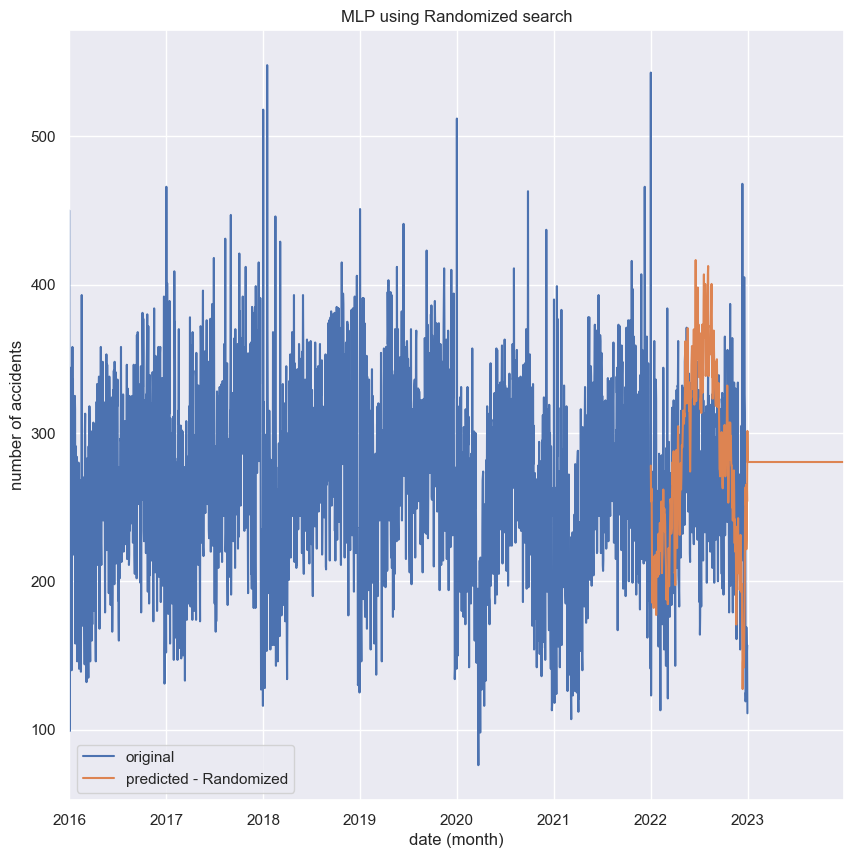

In [89]:
# plot predicted values from MLP model with randomized search cv
mlp_predict_df['predicted - Randomized'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Randomized']].plot()
plt.title("MLP using Randomized search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [90]:
# grid for MLP and Grid search CV
mlp_grid = {
    "hidden_layer_sizes": [10, 250, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}

In [91]:
mlp_estimator_grid = GridSearchCV(estimator=mlp,
                                  scoring='neg_root_mean_squared_error',
                                  param_grid = mlp_grid_randomized,
                                  n_jobs=-1,
                                  error_score='raise'
                                 )

In [92]:
mlp_estimator_grid.fit(X_train_scale, y_train_scale)

GridSearchCV(error_score='raise',
             estimator=MLPRegressor(alpha=0.0010474603795907434,
                                    hidden_layer_sizes=156,
                                    learning_rate='invscaling', max_iter=162,
                                    random_state=111, solver='sgd'),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [5e-05, 0.05],
                         'hidden_layer_sizes': [10, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [150, 300],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='neg_root_mean_squared_error')

In [93]:
mlp_estimator_grid.best_params_

{'activation': 'relu',
 'alpha': 5e-05,
 'hidden_layer_sizes': 500,
 'learning_rate': 'adaptive',
 'max_iter': 300,
 'solver': 'sgd'}

In [94]:
y_predict_mlp_grid = mlp_estimator_grid.predict(X_test_scale[['day', 'month', 'year', 'temp']])
y_predict_mlp_grid

array([-0.73387176, -0.79609451, -0.77133907, -0.77007954, -0.85497707,
       -0.88643145, -0.89722001, -0.88140961, -0.87960955, -0.85695376,
       -0.91637513, -0.92194005, -0.88306591, -0.84259304, -0.85872056,
       -0.93772968, -0.84961603, -0.91491347, -0.90357171, -0.91983192,
       -1.02737043, -0.90028395, -0.86165977, -0.84655127, -0.87625347,
       -0.93514327, -0.94286072, -0.8453277 , -0.82624561, -0.76237829,
       -0.89741556, -0.81032752, -0.79588846, -0.8000162 , -0.76996511,
       -0.80661064, -0.77963208, -0.80226106, -0.77926881, -0.72385711,
       -0.70533215, -0.77240619, -0.83725616, -0.82049172, -0.81311401,
       -0.77111826, -0.70400772, -0.62375908, -0.68591134, -0.71788021,
       -0.70338556, -0.67654833, -0.76406371, -0.69360466, -0.72960762,
       -0.8106749 , -0.85089741, -0.89470512, -1.02638387, -0.73241663,
       -0.73944623, -0.74671234, -0.75786618, -0.76250804, -0.77966992,
       -0.77898793, -0.76242974, -0.74296419, -0.7654146 , -0.80

In [95]:
# r2 score for MLP regressor with grid search cv
mlp_estimator_grid.score(X_test_scale[['day', 'month', 'year', 'temp']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

-0.8970264070875678

In [96]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_grid.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y', 'temp'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_8728\333026508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_grid.tolist()


day  month    year           y      temp
0     1.0    1.0  2022.0  278.002395  3.830288
1     2.0    1.0  2022.0  253.829874  3.333723
2     3.0    1.0  2022.0  262.693132  3.531283
3     4.0    1.0  2022.0  261.887381  3.541334
4     5.0    1.0  2022.0  222.405597  2.863815
..    ...    ...     ...         ...       ...
725  27.0   12.0  2023.0  280.419647  6.615813
726  28.0   12.0  2023.0  280.419647  6.478385
727  29.0   12.0  2023.0  280.419647  6.337208
728  30.0   12.0  2023.0  280.419647  6.195387
729  31.0   12.0  2023.0  280.419647  6.050795

[730 rows x 5 columns]

Text(0, 0.5, 'number of accidents')

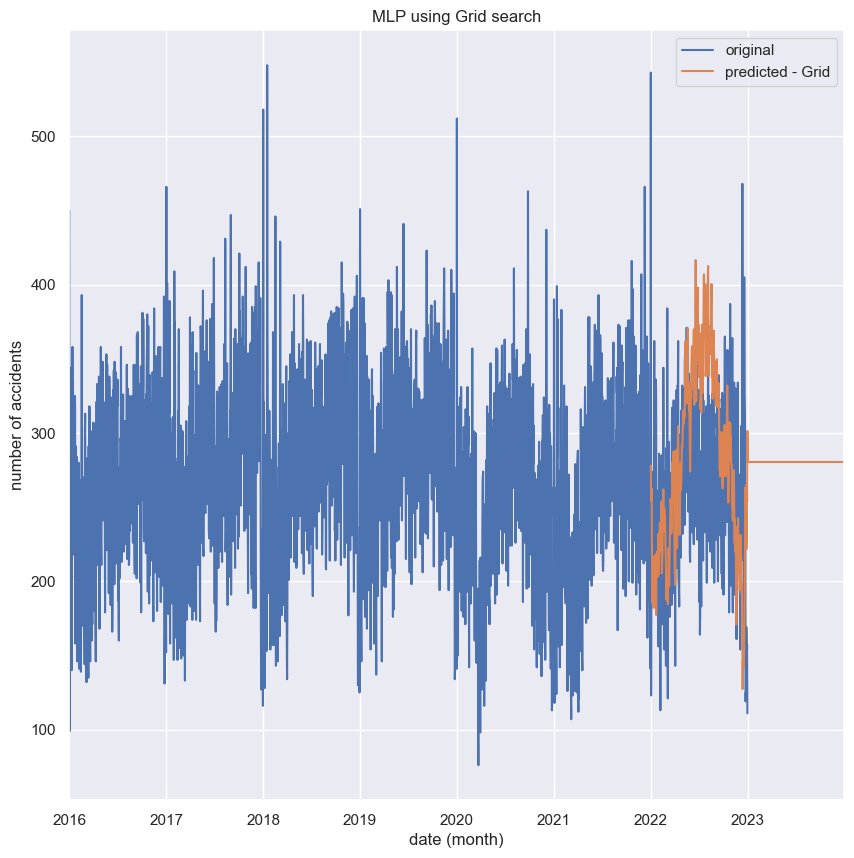

In [97]:
# plot predicted values from MLP model with grid search cv
mlp_predict_df['predicted - Grid'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Grid']].plot()
plt.title("MLP using Grid search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [98]:
predict_df['MLP + GA'] = list(mlp_predict_df['predicted - GA'])
predict_df['MLP + randomized'] = list(mlp_predict_df['predicted - Randomized'])
predict_df['MLP + grid'] = list(mlp_predict_df['predicted - Grid'])

predict_df

original  temp     prophet       arima         svr     xgboost  \
ds                                                                           
2016-01-01     450.0  -0.6         NaN         NaN         NaN         NaN   
2016-01-02     148.0  -0.3         NaN         NaN         NaN         NaN   
2016-01-03      99.0  -4.4         NaN         NaN         NaN         NaN   
2016-01-04     344.0  -5.9         NaN         NaN         NaN         NaN   
2016-01-05     271.0  -4.7         NaN         NaN         NaN         NaN   
...              ...   ...         ...         ...         ...         ...   
2023-12-27       NaN  10.0  313.486752  201.620252  248.666615  168.264496   
2023-12-28       NaN  10.0  310.874906  204.317466  234.969947  151.167664   
2023-12-29       NaN  10.0  328.197688  217.440162  226.118038  154.053253   
2023-12-30       NaN  10.0  237.712232  225.309309  240.963728  153.283981   
2023-12-31       NaN  10.0  209.610036  136.078315  153.172227  115.143616   

              catboost         rnn        lstm  random forest + GA  \
ds                                                                   
2016-01-01         NaN         NaN         NaN                 NaN   
2016-01-02         NaN         NaN         NaN                 NaN   
2016-01-03         NaN         NaN         NaN                 NaN   
2016-01-04         NaN         NaN         NaN                 NaN   
2016-01-05         NaN         NaN         NaN                 NaN   
...                ...         ...         ...                 ...   
2023-12-27  170.111394  288.600009  276.970255          272.038997   
2023-12-28  165.140365  287.503257  269.905862          271.947476   
2023-12-29  157.369136  293.942132  269.660342          271.947476   
2023-12-30  151.179452  285.632991  275.377497          271.947476   
2023-12-31  123.111052  284.703534  280.473256          271.947476   

            random forest + randomized  random forest + grid    MLP + GA  \
ds                                                                         
2016-01-01                         NaN                   NaN         NaN   
2016-01-02                         NaN                   NaN         NaN   
2016-01-03                         NaN                   NaN         NaN   
2016-01-04                         NaN                   NaN         NaN   
2016-01-05                         NaN                   NaN         NaN   
...                                ...                   ...         ...   
2023-12-27                     263.605            262.122698  280.419647   
2023-12-28                     261.560            259.269975  280.419647   
2023-12-29                     261.560            259.269975  280.419647   
2023-12-30                     261.560            259.269975  280.419647   
2023-12-31                     258.785            247.097244  280.419647   

            MLP + randomized  MLP + grid  
ds                                        
2016-01-01               NaN         NaN  
2016-01-02               NaN         NaN  
2016-01-03               NaN         NaN  
2016-01-04               NaN         NaN  
2016-01-05               NaN         NaN  
...                      ...         ...  
2023-12-27        280.419647  280.419647  
2023-12-28        280.419647  280.419647  
2023-12-29        280.419647  280.419647  
2023-12-30        280.419647  280.419647  
2023-12-31        280.419647  280.419647  

[2922 rows x 15 columns]

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [100]:
def create_graph_dataset(dataframe, num_neighbors=21):
    ds_values = pd.to_datetime(dataframe['ds']).values.astype(float)
    y_values = dataframe['y'].values.astype(float)
    temp_values = dataframe['temp'].values.astype(float)

    x = torch.tensor(np.column_stack((y_values, temp_values)), dtype=torch.float32)
    edge_index = torch.zeros((2, 0), dtype=torch.long)

    for i in range(len(ds_values)):
        # num_neighbors nearest timestamps will be edges
        start = max(0, i - num_neighbors)
        end = min(len(ds_values), i + num_neighbors + 1)
        neighbors = list(range(start, i)) + list(range(i + 1, end))
        edges = torch.tensor([[i] * len(neighbors), neighbors], dtype=torch.long)
        edge_index = torch.cat([edge_index, edges], dim=1)

    return Data(x=x, edge_index=edge_index)

# create a graph dataset from the DataFrame with train and test data
train_dataset_gnn = create_graph_dataset(dataset_train)
new_rows = predict_df.reset_index()[['ds']].tail(periods_to_predict)
new_rows['y'] = (dataset_test['y'].to_list() * ((len(new_rows) // len(dataset_test)) + 1))[:len(new_rows)]
new_rows['temp'] = [10] * len(new_rows)
test_dataset_gnn = create_graph_dataset(pd.concat([dataset_test, new_rows]))  # concaternanting with new_rows to add future dates

# create data loaders for training and testing
train_loader = DataLoader([train_dataset_gnn], batch_size=64)
test_loader = DataLoader([test_dataset_gnn], batch_size=64)

In [101]:
# define the GNN model
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TimeSeriesGNN, self).__init__()
        torch.manual_seed(111)
        self.conv1 = GCNConv(in_channels, hidden_channels)  # first layer
        self.conv2 = GCNConv(hidden_channels, out_channels)  # second layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # first GCN layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # second GCN layer
        x = self.conv2(x, edge_index)
        
        return x

# dimensions used for the GNN
input_dim = 2  # dimension of features (number of accidents and temperature)
hidden_dim = 64
output_dim = 2  # dimension of the predicted output

gnn_model = TimeSeriesGNN(input_dim, hidden_dim, output_dim)  # create the GNN model

loss_fn = nn.MSELoss()  # loss function used for regression

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)  # optimizer used for regression

# train the model using the DataLoader object
num_epochs = 500
for epoch in range(num_epochs):
    gnn_model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = gnn_model(data)
        loss = loss_fn(output, data.x)
        loss.backward()
        optimizer.step()

# make predictions
gnn_model.eval()
for data in test_loader:
    output = gnn_model(data)
    y_pred, temp_pred = torch.split(output, 1, dim=1)
    print(y_pred)
    predict_df['GNN'] = [None] * len(dataset_train) + y_pred.flatten().tolist()

tensor([[201.0618],
        [204.6760],
        [208.3067],
        [211.8521],
        [215.2996],
        [218.7374],
        [222.1061],
        [225.3612],
        [228.5248],
        [231.6497],
        [234.6710],
        [237.6385],
        [240.5599],
        [243.4052],
        [246.0823],
        [248.6727],
        [251.2579],
        [253.8049],
        [256.3125],
        [258.7854],
        [261.2583],
        [263.6325],
        [261.8955],
        [260.3076],
        [258.7849],
        [257.3513],
        [256.0288],
        [254.7516],
        [253.4626],
        [252.2159],
        [251.1185],
        [250.0433],
        [248.9481],
        [247.8603],
        [246.8051],
        [245.7390],
        [244.7554],
        [243.9707],
        [243.1968],
        [242.5131],
        [241.8872],
        [241.2944],
        [240.6671],
        [240.0659],
        [239.8611],
        [239.5971],
        [239.3598],
        [239.1480],
        [238.8672],
        [238.5358],


In [102]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [103]:
# add time index
dataset_df['time_idx'] = [i for i in range(1, len(dataset_df) + 1)]
dataset_df['group_id'] = 0
dataset_df['y'] = dataset_df['y'].astype(float)

In [104]:
max_prediction_length = periods_to_predict
max_encoder_length = 7
training_cutoff = dataset_df['time_idx'].max() - max_prediction_length

In [105]:
dataset_df

ds      y  temp  day  month  year  time_idx  group_id
0    2016-01-01  450.0  -0.6    1      1  2016         1         0
1    2016-01-02  148.0  -0.3    2      1  2016         2         0
2    2016-01-03   99.0  -4.4    3      1  2016         3         0
3    2016-01-04  344.0  -5.9    4      1  2016         4         0
4    2016-01-05  271.0  -4.7    5      1  2016         5         0
...         ...    ...   ...  ...    ...   ...       ...       ...
2552 2022-12-27  169.0   2.7   27     12  2022      2553         0
2553 2022-12-28  157.0   3.6   28     12  2022      2554         0
2554 2022-12-29  151.0   8.1   29     12  2022      2555         0
2555 2022-12-30  157.0   6.7   30     12  2022      2556         0
2556 2022-12-31  111.0  12.6   31     12  2022      2557         0

[2557 rows x 8 columns]

In [106]:
training = TimeSeriesDataSet(
    dataset_df[lambda x: x.time_idx < training_cutoff],
    time_idx='time_idx',
    target='y',
    group_ids=['group_id'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=['temp'],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['time_idx', 'temp'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [107]:
validation = TimeSeriesDataSet.from_dataset(
  training, # dataset from which to copy parameters (encoders, scalers, ...)
  dataset_df.tail(periods_to_predict+(max_encoder_length//2)), # data from which new dataset will be generated
  predict=True, # predict the decoder length on the last entries in the time index
  stop_randomization=True,
)

In [108]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [109]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer='Adam',
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 19.8k


C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [110]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\katka\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (19) is smaller than the

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [111]:
# load the best model according to the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [112]:
predictions = best_tft.predict(val_dataloader)

In [113]:
new_rows_transformer = predict_df.tail(periods_to_predict+(max_encoder_length//2)).reset_index()[['ds', 'temp']]
new_rows_transformer['time_idx'] = [i for i in range(dataset_df['time_idx'].max() + 1, dataset_df['time_idx'].max() + len(new_rows_transformer) + 1)]
new_rows_transformer['group_id'] = 0
new_rows_transformer['y'] = [0] * len(new_rows_transformer)
new_predictions = best_tft.predict(new_rows_transformer).tolist()[0]

In [114]:
predict_df['transformer'] = [None] * (len(predict_df) - 2 * periods_to_predict) + predictions.tolist()[0] + new_predictions

In [115]:
from autots import AutoTS, create_regressor

In [116]:
autots_model = AutoTS(forecast_length=periods_to_predict,
                     model_list='fast',
                     max_generations=8)

future_regressor_train, future_regressor_forecast = create_regressor(
    predict_df[['temp']],
    forecast_length=periods_to_predict + periods_to_predict
)

autots_model = autots_model.fit(dataset_train, date_col='ds', value_col='y', id_col=None, future_regressor=future_regressor_train)

Inferred frequency is: D
future_regressor row count does not match length of training data
Model Number: 1 with model AverageValueNaive in generation 0 of 8
Model Number: 2 with model AverageValueNaive in generation 0 of 8
Model Number: 3 with model AverageValueNaive in generation 0 of 8
Model Number: 4 with model DatepartRegression in generation 0 of 8
Model Number: 5 with model DatepartRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 6 with model DatepartRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 7 with model DatepartRegression in generation 0 of 8
Epoch 1/50
58/58 [==============================] - 8s 6ms/step - loss: 0.3642
Epoch 2/50
58/58 [==============================] - 1s 11ms/step - loss: 0.3136
Epoch 3/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2947
Epoch 4/50
58/58 [==============================] - 1s 11ms/step - loss: 0.2834
Epoch 5/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2740
Epoch 6/50
58/58 [==============================] - 0s 7ms/step - loss: 0.2636
Epoch 7/50
58/58 [==============================] - 1s 9ms/step - loss: 0.2593
Epoch 8/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2661
Epoch 9/50
58/58 [==============================] - 1s 9ms/step - loss: 0.2536
Epoch 10/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2548
Epoch 11/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2519
Epoch 12/50
58/58 [==============================] - 0s 8ms/

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 27 with model DatepartRegression in generation 0 of 8
Model Number: 28 with model SeasonalNaive in generation 0 of 8
Model Number: 29 with model DatepartRegression in generation 0 of 8
Model Number: 30 with model ETS in generation 0 of 8
Model Number: 31 with model VECM in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VECM') in model 31 in generation 0: VECM
Model Number: 32 with model MultivariateMotif in generation 0 of 8
Model Number: 33 with model MultivariateMotif in generation 0 of 8
Model Number: 34 with model UnivariateMotif in generation 0 of 8
Model Number: 35 with model UnivariateMotif in generation 0 of 8
Model Number: 36 with model SectionalMotif in generation 0 of 8
Model Number: 37 with model SectionalMotif in generation 0 of 8
Model Number: 38 with model SeasonalNaive in generation 0 of 8
Model Number: 39 with model DatepartRegression in generation 0 of 8
Model Number: 40 with model NVAR in generation 0 of 8
Model Number: 41 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 48 with model ETS in generation 0 of 8
Model Number: 49 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 49 in generation 0: VAR
Model Number: 50 with model VECM in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VECM') in model 50 in generation 0: VECM
Model Number: 51 with model WindowRegression in generation 0 of 8
Model Number: 52 with model DatepartRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 53 with model UnivariateMotif in generation 0 of 8
Model Number: 54 with model MultivariateMotif in generation 0 of 8
Model Number: 55 with model SectionalMotif in generation 0 of 8
Model Number: 56 with model NVAR in generation 0 of 8
Model Number: 57 with model MAR in generation 0 of 8
Template Eval Error: ValueError('Shape of passed values is (98, 1), indices imply (365, 1)') in model 57 in generation 0: MAR
Model Number: 58 with model RRVAR in generation 0 of 8
Model Number: 59 with model KalmanStateSpace in generation 0 of 8
Model Number: 60 with model MetricMotif in generation 0 of 8
Model Number: 61 with model Cassandra in generation 0 of 8
Model Number: 62 with model SeasonalityMotif in generation 0 of 8
Model Number: 63 with model ConstantNaive in generation 0 of 8
Model Number: 64 with model AverageValueNaive in generation 0 of 8
Model Number: 65 with model ETS in generation 0 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 78 with model ETS in generation 0 of 8
Model Number: 79 with model ETS in generation 0 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 79 in generation 0: ETS
Model Number: 80 with model ConstantNaive in generation 0 of 8
Model Number: 81 with model GLM in generation 0 of 8
Model Number: 82 with model ETS in generation 0 of 8
Model Number: 83 with model LastValueNaive in generation 0 of 8
Model Number: 84 with model AverageValueNaive in generation 0 of 8
Model Number: 85 with model WindowRegression in generation 0 of 8
Model Number: 86 with model MultivariateMotif in generation 0 of 8
Model Number: 87 with model VECM in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VECM') in model 87 in generation 0: VECM
Model Number: 88 with model LastValueNaive in generation 0 of 8
Model Number: 89 with model MetricMotif in generation 0 of 8
Model Number: 90 with model VECM in generation 0 of 8
Template Eval Er

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 94 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 94 in generation 0: VAR
Model Number: 95 with model RRVAR in generation 0 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 95 in generation 0: RRVAR
Model Number: 96 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 96 in generation 0: VAR
Model Number: 97 with model ConstantNaive in generation 0 of 8
Model Number: 98 with model UnivariateMotif in generation 0 of 8
Model Number: 99 with model AverageValueNaive in generation 0 of 8
Model Number: 100 with model SeasonalNaive in generation 0 of 8
Model Number: 101 with model SeasonalNaive in generation 0 of 8
Model Number: 102 with model ConstantNaive in generation 0 of 8
Model Number: 103 with model MetricMotif in generation 0 of 8
Model Number: 104 with model LastValueNaive in generation 0 of 8
Model Number: 1

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 137 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 137 in generation 0: VAR
Model Number: 138 with model MetricMotif in generation 0 of 8
Model Number: 139 with model AverageValueNaive in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 140 with model RRVAR in generation 0 of 8
Model Number: 141 with model VAR in generation 0 of 8
Template Eval Error: ValueError('Only gave one variable to VAR') in model 141 in generation 0: VAR
Model Number: 142 with model MetricMotif in generation 0 of 8
Model Number: 143 with model WindowRegression in generation 0 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Model Number: 144 with model GLS in generation 0 of 8
Model Number: 145 with model SeasonalityMotif in generation 0 of 8
Model Number: 146 with model DatepartRegression in generation 0 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword argument 'estimator'") in model 146 in generation 0: DatepartRegression
New Generation: 1 of 8
Model Number: 147 with model SectionalMotif in generation 1 of 8
Model Number: 148 with model MultivariateMotif in generation 1 of 8
Model Number: 149 with model Cassandra in generation 1 of 8
Model Number: 150 with model DatepartRegression in generation 1 of 8
Epoch 1/50
46/46 [==============================] - 5s 69ms/step - loss: nan - val_loss: nan
Epoch 2/50
46/46 [==============================] - 2s 50ms/step - loss: nan - val_loss: nan
Epoch 3/50
46/46 [==============================] - 2s 55ms/step - loss: nan - val_loss: nan
Epoch 4/50
46/46 [==============================] - 2s 37ms/step - loss: nan - val_loss: nan
Epoch 5/50
4

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 162 with model NVAR in generation 1 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 162 in generation 1: NVAR
Model Number: 163 with model ETS in generation 1 of 8
Model Number: 164 with model GLM in generation 1 of 8
Model Number: 165 with model GLS in generation 1 of 8
Model Number: 166 with model LastValueNaive in generation 1 of 8
Model Number: 167 with model MetricMotif in generation 1 of 8
Model Number: 168 with model UnivariateMotif in generation 1 of 8
Model Number: 169 with model SeasonalityMotif in generation 1 of 8
Model Number: 170 with model SectionalMotif in generation 1 of 8
Model Number: 171 with model WindowRegression in generation 1 of 8
Template Eval Error: LightGBMError('[poisson]: at least one target label is negative') in model 171 in generation 1: WindowRegression
Model Number: 172 with model WindowRegression in generation 1 of 8
Model Number: 173 with model MetricMotif in generation 1 of 8
Model Number: 174 with model

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 183 with model GLM in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 184 with model MultivariateMotif in generation 1 of 8
Model Number: 185 with model Cassandra in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


the following columns contain nan values: ['regr_temp', 'regr_day', 'regr_weekend', 'regr_epoch', 'regr_month_1', 'regr_month_2', 'regr_month_3', 'regr_month_4', 'regr_month_5', 'regr_month_6', 'regr_month_7', 'regr_month_8', 'regr_month_9', 'regr_month_10', 'regr_month_11', 'regr_month_12', 'regr_weekday_0', 'regr_weekday_1', 'regr_weekday_2', 'regr_weekday_3', 'regr_weekday_4', 'regr_weekday_5', 'regr_weekday_6', 'regr_HolidayFlag_US', 'regr_holiday_flag_US_future']
Template Eval Error: ValueError('nan values in predict_x_array') in model 185 in generation 1: Cassandra
Model Number: 186 with model DatepartRegression in generation 1 of 8
Model Number: 187 with model GLM in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 188 with model WindowRegression in generation 1 of 8
Model Number: 189 with model RRVAR in generation 1 of 8
Model Number: 190 with model SectionalMotif in generation 1 of 8
Model Number: 191 with model AverageValueNaive in generation 1 of 8
Model Number: 192 with model MetricMotif in generation 1 of 8
Model Number: 193 with model UnivariateMotif in generation 1 of 8
Model Number: 194 with model RRVAR in generation 1 of 8
Model Number: 195 with model DatepartRegression in generation 1 of 8
Model Number: 196 with model WindowRegression in generation 1 of 8
Model Number: 197 with model SeasonalNaive in generation 1 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 197 in generation 1: SeasonalNaive
Model Number: 198 with model AverageValueNaive in generation 1 of 8
Model Number: 199 with model AverageValueNaive in generation 1 of 8
Model Number: 200 with model SeasonalityMotif in generation 1 of 8
Model Number: 201 with model ETS in generation 1

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 214 with model DatepartRegression in generation 1 of 8
Model Number: 215 with model WindowRegression in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+04, tolerance: 4.921e+00
  model = cd_fast.enet_coordinate_descent(


Model Number: 216 with model MultivariateMotif in generation 1 of 8
Model Number: 217 with model WindowRegression in generation 1 of 8
Model Number: 218 with model ConstantNaive in generation 1 of 8
Model Number: 219 with model GLS in generation 1 of 8
Model Number: 220 with model SeasonalityMotif in generation 1 of 8
Model Number: 221 with model GLS in generation 1 of 8
Model Number: 222 with model DatepartRegression in generation 1 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword argument 'estimator'") in model 222 in generation 1: DatepartRegression
Model Number: 223 with model SeasonalNaive in generation 1 of 8
Model Number: 224 with model ETS in generation 1 of 8
Model Number: 225 with model GLM in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 226 with model AverageValueNaive in generation 1 of 8
Model Number: 227 with model MetricMotif in generation 1 of 8
Model Number: 228 with model MetricMotif in generation 1 of 8
Model Number: 229 with model DatepartRegression in generation 1 of 8
Model Number: 230 with model GLM in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 231 with model DatepartRegression in generation 1 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword argument 'estimator'") in model 231 in generation 1: DatepartRegression
Model Number: 232 with model RRVAR in generation 1 of 8
Model Number: 233 with model ETS in generation 1 of 8
Model Number: 234 with model SeasonalityMotif in generation 1 of 8
Model Number: 235 with model DatepartRegression in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


Model Number: 236 with model UnivariateMotif in generation 1 of 8
Model Number: 237 with model Cassandra in generation 1 of 8
Model Number: 238 with model RRVAR in generation 1 of 8
Model Number: 239 with model AverageValueNaive in generation 1 of 8
Model Number: 240 with model MultivariateMotif in generation 1 of 8
Model Number: 241 with model KalmanStateSpace in generation 1 of 8
Model Number: 242 with model RRVAR in generation 1 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 242 in generation 1: RRVAR
Model Number: 243 with model RRVAR in generation 1 of 8
Model Number: 244 with model MetricMotif in generation 1 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 245 with model KalmanStateSpace in generation 1 of 8
Model Number: 246 with model WindowRegression in generation 1 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 254 with model AverageValueNaive in generation 2 of 8
Model Number: 255 with model RRVAR in generation 2 of 8
Model Number: 256 with model KalmanStateSpace in generation 2 of 8
Model Number: 257 with model WindowRegression in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\Users\katka\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature nam

Model Number: 258 with model SeasonalityMotif in generation 2 of 8
Model Number: 259 with model LastValueNaive in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in double_scalars
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 260 with model SectionalMotif in generation 2 of 8
Model Number: 261 with model SeasonalNaive in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


Model Number: 262 with model UnivariateMotif in generation 2 of 8
Model Number: 263 with model LastValueNaive in generation 2 of 8
Model Number: 264 with model UnivariateMotif in generation 2 of 8
Model Number: 265 with model DatepartRegression in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 266 with model SeasonalityMotif in generation 2 of 8
Model Number: 267 with model WindowRegression in generation 2 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 267 in generation 2: WindowRegression
Model Number: 268 with model GLM in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 269 with model WindowRegression in generation 2 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 269 in generation 2: WindowRegression
Model Number: 270 with model GLM in generation 2 of 8
Model Number: 271 with model SeasonalityMotif in generation 2 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 271 in generation 2: SeasonalityMotif
Model Number: 272 with model KalmanStateSpace in generation 2 of 8
Model Number: 273 with model SectionalMotif in generation 2 of 8
Model Number: 274 with model UnivariateMotif in generation 2 of 8
Model Number: 275 with model AverageValueNaive in generation 2 of 8
Model Number: 276 with model WindowRegression in generation 2 of 8
Model Number: 277 with model DatepartRegression in generation 2 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword argument 'estimator'") in model 277 in generation 2: DatepartRegression
Model Number: 278 with model Un

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 280 with model DatepartRegression in generation 2 of 8
Model Number: 281 with model WindowRegression in generation 2 of 8
Model Number: 282 with model SeasonalityMotif in generation 2 of 8
Model Number: 283 with model WindowRegression in generation 2 of 8
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 283 in generation 2: WindowRegression
Model Number: 284 with model AverageValueNaive in generation 2 of 8
Model Number: 285 with model Cassandra in generation 2 of 8
Model Number: 286 with model LastValueNaive in generation 2 of 8
Model Number: 287 with model UnivariateMotif in generation 2 of 8
Model Number: 288 with model RRVAR in generation 2 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 288 in generation 2: RRVAR
Model Number: 289 with model SeasonalNaive in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 289 in generation 2: SeasonalNaive
Model Number: 290 with model GLM in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)


Model Number: 291 with model WindowRegression in generation 2 of 8
Model Number: 292 with model MetricMotif in generation 2 of 8
Model Number: 293 with model DatepartRegression in generation 2 of 8
Epoch 1/50
58/58 [==============================] - 10s 11ms/step - loss: 0.4788
Epoch 2/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4492
Epoch 3/50
58/58 [==============================] - 1s 10ms/step - loss: 0.4384
Epoch 4/50
58/58 [==============================] - 0s 7ms/step - loss: 0.4198
Epoch 5/50
58/58 [==============================] - 1s 10ms/step - loss: 0.4076
Epoch 6/50
58/58 [==============================] - 0s 7ms/step - loss: 0.3940
Epoch 7/50
58/58 [==============================] - 1s 10ms/step - loss: 0.3746
Epoch 8/50
58/58 [==============================] - 0s 7ms/step - loss: 0.3695
Epoch 9/50
58/58 [==============================] - 1s 9ms/step - loss: 0.3630
Epoch 10/50
58/58 [==============================] - 0s 7ms/step - loss: 0.3574
Epoch 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 312 with model SeasonalityMotif in generation 2 of 8
Model Number: 313 with model MultivariateMotif in generation 2 of 8
Model Number: 314 with model SeasonalityMotif in generation 2 of 8
Model Number: 315 with model GLM in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 316 with model ConstantNaive in generation 2 of 8
Model Number: 317 with model RRVAR in generation 2 of 8
Model Number: 318 with model AverageValueNaive in generation 2 of 8
Model Number: 319 with model MultivariateMotif in generation 2 of 8
Model Number: 320 with model Cassandra in generation 2 of 8
the following columns contain nan values: ['regr_temp', 'regr_day', 'regr_weekend', 'regr_epoch', 'regr_month_1', 'regr_month_2', 'regr_month_3', 'regr_month_4', 'regr_month_5', 'regr_month_6', 'regr_month_7', 'regr_month_8', 'regr_month_9', 'regr_month_10', 'regr_month_11', 'regr_month_12', 'regr_weekday_0', 'regr_weekday_1', 'regr_weekday_2', 'regr_weekday_3', 'regr_weekday_4', 'regr_weekday_5', 'regr_weekday_6', 'regr_HolidayFlag_US', 'regr_holiday_flag_US_future']
Template Eval Error: ValueError('nan values in predict_x_array') in model 320 in generation 2: Cassandra
Model Number: 321 with model WindowRegression in generation 2 of 8
Model Number: 322 with model Univariate

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 344 with model SeasonalityMotif in generation 2 of 8
Model Number: 345 with model RRVAR in generation 2 of 8
Model Number: 346 with model NVAR in generation 2 of 8
Model Number: 347 with model SeasonalNaive in generation 2 of 8
Model Number: 348 with model NVAR in generation 2 of 8
Model Number: 349 with model LastValueNaive in generation 2 of 8
Model Number: 350 with model SectionalMotif in generation 2 of 8
Model Number: 351 with model AverageValueNaive in generation 2 of 8
Model Number: 352 with model SeasonalityMotif in generation 2 of 8
Model Number: 353 with model GLM in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 354 with model GLM in generation 2 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 355 with model SectionalMotif in generation 2 of 8
Model Number: 356 with model RRVAR in generation 2 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 356 in generation 2: RRVAR
New Generation: 3 of 8
Model Number: 357 with model SeasonalityMotif in generation 3 of 8
Model Number: 358 with model DatepartRegression in generation 3 of 8
Model Number: 359 with model LastValueNaive in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


Model Number: 360 with model SectionalMotif in generation 3 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 360 in generation 3: SectionalMotif
Model Number: 361 with model DatepartRegression in generation 3 of 8
Model Number: 362 with model RRVAR in generation 3 of 8
Model Number: 363 with model GLS in generation 3 of 8
Model Number: 364 with model SeasonalNaive in generation 3 of 8
Model Number: 365 with model UnivariateMotif in generation 3 of 8
Model Number: 366 with model RRVAR in generation 3 of 8
Model Number: 367 with model Cassandra in generation 3 of 8
Model Number: 368 with model WindowRegression in generation 3 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1650: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 369 in generation 3: GLM
Model Number: 370 with model GLM in generation 3 of 8
Model Number: 371 with model DatepartRegression in generation 3 of 8
Model Number: 372 with model UnivariateMotif in generation 3 of 8
Model Number: 373 with model Cassandra in generation 3 of 8
Model Number: 374 with model WindowRegression in generation 3 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 379 with model DatepartRegression in generation 3 of 8
Model Number: 380 with model SectionalMotif in generation 3 of 8
HolidayTransformer: no anomalies detected.
Model Number: 381 with model UnivariateMotif in generation 3 of 8
Model Number: 382 with model SectionalMotif in generation 3 of 8
Model Number: 383 with model MetricMotif in generation 3 of 8
Model Number: 384 with model SeasonalNaive in generation 3 of 8
Model Number: 385 with model KalmanStateSpace in generation 3 of 8
HolidayTransformer: no anomalies detected.
Model Number: 386 with model SeasonalNaive in generation 3 of 8
Model Number: 387 with model SeasonalNaive in generation 3 of 8
Model Number: 388 with model NVAR in generation 3 of 8
Model Number: 389 with model SeasonalNaive in generation 3 of 8
Model Number: 390 with model ETS in generation 3 of 8
Model Number: 391 with model DatepartRegression in generation 3 of 8
Model Number: 392 with model SectionalMotif in generation 3 of 8
Model Number: 393 wit

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:813: RuntimeWarning: overflow encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:348: RuntimeWarning: overflow encountered in power
  return self.power * np.power(p, self.power - 1)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1243: RuntimeWarning: overflow encountered in multiply
  wlsendog = (li

Template Eval Error: ValueError('NaN, inf or invalid value detected in endog, estimation infeasible.') in model 397 in generation 3: GLM
Model Number: 398 with model MultivariateMotif in generation 3 of 8
Model Number: 399 with model KalmanStateSpace in generation 3 of 8
Model Number: 400 with model GLM in generation 3 of 8
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 400 in generation 3: GLM
Model Number: 401 with model DatepartRegression in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 402 with model UnivariateMotif in generation 3 of 8
Model Number: 403 with model GLM in generation 3 of 8
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 403 in generation 3: GLM
Model Number: 404 with model GLM in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1243: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genm

Model Number: 405 with model MultivariateMotif in generation 3 of 8
Model Number: 406 with model GLS in generation 3 of 8
Model Number: 407 with model SeasonalityMotif in generation 3 of 8
Model Number: 408 with model WindowRegression in generation 3 of 8
Model Number: 409 with model DatepartRegression in generation 3 of 8
Model Number: 410 with model SectionalMotif in generation 3 of 8
HolidayTransformer: no anomalies detected.
Model Number: 411 with model KalmanStateSpace in generation 3 of 8
Model Number: 412 with model Cassandra in generation 3 of 8
Model Number: 413 with model UnivariateMotif in generation 3 of 8
Model Number: 414 with model SeasonalityMotif in generation 3 of 8
Model Number: 415 with model LastValueNaive in generation 3 of 8
HolidayTransformer: no anomalies detected.
Model Number: 416 with model GLS in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


Model Number: 417 with model SeasonalNaive in generation 3 of 8
Model Number: 418 with model SectionalMotif in generation 3 of 8
Model Number: 419 with model SectionalMotif in generation 3 of 8
Model Number: 420 with model NVAR in generation 3 of 8
Model Number: 421 with model Cassandra in generation 3 of 8
Template Eval Error: ValueError('Found array with 1 feature(s) (shape=(1827, 1)) while a minimum of 2 is required by FeatureAgglomeration.') in model 421 in generation 3: Cassandra
Model Number: 422 with model AverageValueNaive in generation 3 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 423 with model WindowRegression in generation 3 of 8
Template Eval Error: AttributeError("'NoneType' object has no attribute 'split'") in model 423 in generation 3: WindowRegression
Model Number: 424 with model AverageValueNaive in generation 3 of 8
Model Number: 425 with model GLM in generation 3 of 8
Model Number: 426 with model UnivariateMotif in generation 3 of 8
Model Number: 427 with model SeasonalityMotif in generation 3 of 8
Model Number: 428 with model DatepartRegression in generation 3 of 8
Model Number: 429 with model WindowRegression in generation 3 of 8
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 429 in generation 3: WindowRegression
Model Number: 430 with model WindowRegression in generation 3 of 8
Model Number: 431 with model SectionalMotif in generation 3 of 8
Model Number: 432 with model GLS in generation 3 of 8
Model Number: 433 with model Cassandra in generation 3 of 8
Model Nu

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 437 with model GLS in generation 3 of 8
Model Number: 438 with model AverageValueNaive in generation 3 of 8
Model Number: 439 with model GLS in generation 3 of 8
Model Number: 440 with model WindowRegression in generation 3 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Model Number: 463 with model AverageValueNaive in generation 4 of 8
Model Number: 464 with model WindowRegression in generation 4 of 8
Model Number: 465 with model GLS in generation 4 of 8
Model Number: 466 with model DatepartRegression in generation 4 of 8
Model Number: 467 with model UnivariateMotif in generation 4 of 8
Model Number: 468 with model MetricMotif in generation 4 of 8
Model Number: 469 with model DatepartRegression in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 470 with model NVAR in generation 4 of 8
Model Number: 471 with model SeasonalNaive in generation 4 of 8
Model Number: 472 with model Cassandra in generation 4 of 8
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 473 with model WindowRegression in generation 4 of 8
Model Number: 474 with model ConstantNaive in generation 4 of 8
Model Number: 475 with model SeasonalNaive in generation 4 of 8
Model Number: 476 with model ETS in generation 4 of 8
Model Number: 477 with model AverageValueNaive in generation 4 of 8
Model Number: 478 with model MetricMotif in generation 4 of 8
Model Number: 479 with model SeasonalNaive in generation 4 of 8
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 479 in generation 4: SeasonalNaive
Model Number: 480 with model SeasonalNaive in generation 4 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 480 in generation 4: SeasonalNaive
Model Number: 481 with model ETS in generation 4 of 8
Model Number: 482 with model KalmanStateSpace in generation 4 of 8
Model Number: 483 with model SectionalMotif in generation 4 of 8
Model Number: 484 with model SeasonalNaive in 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 486 with model SectionalMotif in generation 4 of 8
HolidayTransformer: no anomalies detected.
Model Number: 487 with model Cassandra in generation 4 of 8
Model Number: 488 with model WindowRegression in generation 4 of 8
Template Eval Error: Exception('Transformer AnomalyRemoval failed on fit') in model 488 in generation 4: WindowRegression
Model Number: 489 with model UnivariateMotif in generation 4 of 8
Model Number: 490 with model MultivariateMotif in generation 4 of 8
Model Number: 491 with model RRVAR in generation 4 of 8
Model Number: 492 with model DatepartRegression in generation 4 of 8
HolidayTransformer: no anomalies detected.
Model Number: 493 with model SeasonalityMotif in generation 4 of 8
Model Number: 494 with model AverageValueNaive in generation 4 of 8
Model Number: 495 with model SeasonalityMotif in generation 4 of 8
Model Number: 496 with model DatepartRegression in generation 4 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword a

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


the following columns contain nan values: ['regr_temp', 'regr_day', 'regr_weekend', 'regr_epoch', 'regr_month_1', 'regr_month_2', 'regr_month_3', 'regr_month_4', 'regr_month_5', 'regr_month_6', 'regr_month_7', 'regr_month_8', 'regr_month_9', 'regr_month_10', 'regr_month_11', 'regr_month_12', 'regr_weekday_0', 'regr_weekday_1', 'regr_weekday_2', 'regr_weekday_3', 'regr_weekday_4', 'regr_weekday_5', 'regr_weekday_6', 'regr_HolidayFlag_US', 'regr_holiday_flag_US_future']
Template Eval Error: ValueError('nan values in predict_x_array') in model 498 in generation 4: Cassandra
Model Number: 499 with model WindowRegression in generation 4 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0001

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 506 with model WindowRegression in generation 4 of 8
Model Number: 507 with model DatepartRegression in generation 4 of 8
Model Number: 508 with model Cassandra in generation 4 of 8
Model Number: 509 with model AverageValueNaive in generation 4 of 8
Model Number: 510 with model DatepartRegression in generation 4 of 8
Model Number: 511 with model ETS in generation 4 of 8
Model Number: 512 with model SeasonalityMotif in generation 4 of 8
Model Number: 513 with model DatepartRegression in generation 4 of 8
Model Number: 514 with model GLS in generation 4 of 8
Model Number: 515 with model GLS in generation 4 of 8
Model Number: 516 with model SeasonalNaive in generation 4 of 8
Model Number: 517 with model SeasonalNaive in generation 4 of 8
Model Number: 518 with model MultivariateMotif in generation 4 of 8
Model Number: 519 with model SeasonalityMotif in generation 4 of 8
Model Number: 520 with model GLM in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 521 with model SectionalMotif in generation 4 of 8
HolidayTransformer: no anomalies detected.
Model Number: 522 with model DatepartRegression in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 523 with model GLS in generation 4 of 8
Model Number: 524 with model ConstantNaive in generation 4 of 8
Model Number: 525 with model SeasonalityMotif in generation 4 of 8
Model Number: 526 with model WindowRegression in generation 4 of 8
Model Number: 527 with model SeasonalityMotif in generation 4 of 8
Model Number: 528 with model DatepartRegression in generation 4 of 8
Model Number: 529 with model DatepartRegression in generation 4 of 8
Model Number: 530 with model GLS in generation 4 of 8
Model Number: 531 with model RRVAR in generation 4 of 8
Model Number: 532 with model GLS in generation 4 of 8
Model Number: 533 with model AverageValueNaive in generation 4 of 8
Model Number: 534 with model SeasonalityMotif in generation 4 of 8
Model Number: 535 with model MultivariateMotif in generation 4 of 8
Model Number: 536 with model UnivariateMotif in generation 4 of 8
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 536 in generation 4: Uni

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 553 in generation 4: GLM
Model Number: 554 with model GLM in generation 4 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 555 with model MultivariateMotif in generation 4 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 555 in generation 4: MultivariateMotif
Model Number: 556 with model WindowRegression in generation 4 of 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 557 with model KalmanStateSpace in generation 4 of 8
Model Number: 558 with model SeasonalNaive in generation 4 of 8
Model Number: 559 with model RRVAR in generation 4 of 8
Model Number: 560 with model Cassandra in generation 4 of 8
Model Number: 561 with model RRVAR in generation 4 of 8
Model Number: 562 with model LastValueNaive in generation 4 of 8
Model Number: 563 with model MetricMotif in generation 4 of 8
Model Number: 564 with model LastValueNaive in generation 4 of 8
Model Number: 565 with model Cassandra in generation 4 of 8
Template Eval Error: Va

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
New Generation: 5 of 8
Model Number: 567 with model Cassandra in generation 5 of 8
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 567 in generation 5: Cassandra
Model Number: 568 with model SeasonalNaive in generation 5 of 8
Model Number: 569 with model NVAR in generation 5 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 569 in generation 5: NVAR
Model Number: 570 with model Cassandra in generation 5 of 8
Model Number: 571 with model SeasonalNaive in generation 5 of 8
Model Number: 572 with model LastValueNaive in generation 5 of 8
Model Number: 573 with model WindowRegression in generation 5 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [W

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.060e+05, tolerance: 1.566e+02
  model = cd_fast.enet_coordinate_descent(


Model Number: 577 with model SectionalMotif in generation 5 of 8
HolidayTransformer: no anomalies detected.
Model Number: 578 with model ConstantNaive in generation 5 of 8
Model Number: 579 with model NVAR in generation 5 of 8
Model Number: 580 with model SectionalMotif in generation 5 of 8
Model Number: 581 with model SectionalMotif in generation 5 of 8
Model Number: 582 with model NVAR in generation 5 of 8
Model Number: 583 with model GLS in generation 5 of 8
Model Number: 584 with model SeasonalityMotif in generation 5 of 8
HolidayTransformer: no anomalies detected.
Model Number: 585 with model WindowRegression in generation 5 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431

C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 589 with model MultivariateMotif in generation 5 of 8
Model Number: 590 with model DatepartRegression in generation 5 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 590 in generation 5: DatepartRegression
Model Number: 591 with model NVAR in generation 5 of 8
Model Number: 592 with model DatepartRegression in generation 5 of 8
Model Number: 593 with model MultivariateMotif in generation 5 of 8
Model Number: 594 with model AverageValueNaive in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.322e+02, tolerance: 1.820e-01
  model = cd_fast.enet_coordinate_descent(


Model Number: 595 with model AverageValueNaive in generation 5 of 8
Model Number: 596 with model SeasonalityMotif in generation 5 of 8
Model Number: 597 with model SectionalMotif in generation 5 of 8
Model Number: 598 with model UnivariateMotif in generation 5 of 8
Model Number: 599 with model AverageValueNaive in generation 5 of 8
HolidayTransformer: no anomalies detected.
Model Number: 600 with model UnivariateMotif in generation 5 of 8
Model Number: 601 with model DatepartRegression in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 602 with model SeasonalNaive in generation 5 of 8
Model Number: 603 with model SeasonalityMotif in generation 5 of 8
Model Number: 604 with model DatepartRegression in generation 5 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword argument 'estimator'") in model 604 in generation 5: DatepartRegression
Model Number: 605 with model GLS in generation 5 of 8
Model Number: 606 with model ETS in generation 5 of 8
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 607 with model KalmanStateSpace in generation 5 of 8
Model Number: 608 with model SeasonalNaive in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 609 with model MultivariateMotif in generation 5 of 8
Model Number: 610 with model UnivariateMotif in generation 5 of 8
Model Number: 611 with model ConstantNaive in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 612 with model DatepartRegression in generation 5 of 8
Model Number: 613 with model Cassandra in generation 5 of 8
Model Number: 614 with model SeasonalNaive in generation 5 of 8
Model Number: 615 with model SeasonalNaive in generation 5 of 8
Model Number: 616 with model RRVAR in generation 5 of 8
Model Number: 617 with model SectionalMotif in generation 5 of 8
Model Number: 618 with model Cassandra in generation 5 of 8
Model Number: 619 with model SeasonalityMotif in generation 5 of 8
Model Number: 620 with model MetricMotif in generation 5 of 8
Model Number: 621 with model SeasonalityMotif in generation 5 of 8
Model Number: 622 with model AverageValueNaive in generation 5 of 8
Model Number: 623 with model GLS in generation 5 of 8
Model Number: 624 with model DatepartRegression in generation 5 of 8
Model Number: 625 with model GLM in generation 5 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 625 in generation 5: GLM
Model Number: 626 with

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 629 with model SeasonalityMotif in generation 5 of 8
Model Number: 630 with model UnivariateMotif in generation 5 of 8
Model Number: 631 with model DatepartRegression in generation 5 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 631 in generation 5: DatepartRegression
Model Number: 632 with model RRVAR in generation 5 of 8
Model Number: 633 with model NVAR in generation 5 of 8
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 633 in generation 5: NVAR
Model Number: 634 with model ConstantNaive in generation 5 of 8
Model Number: 635 with model DatepartRegression in generation 5 of 8
Model Number: 636 with model GLM in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 637 with model MultivariateMotif in generation 5 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 637 in generation 5: MultivariateMotif
Model Number: 638 with model UnivariateMotif in generation 5 of 8
Model Number: 639 with model SeasonalityMotif in generation 5 of 8
Model Number: 640 with model SectionalMotif in generation 5 of 8
Model Number: 641 with model GLM in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 642 with model GLS in generation 5 of 8
Model Number: 643 with model DatepartRegression in generation 5 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 644 with model WindowRegression in generation 5 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model Number: 645 with model SeasonalNaive in generation 5 of 8
Model Number: 646 with model WindowRegression in generation 5 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may

C:\Users\katka\anaconda3\lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in double_scalars
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 663 with model SeasonalityMotif in generation 6 of 8
Model Number: 664 with model SeasonalityMotif in generation 6 of 8
Model Number: 665 with model SectionalMotif in generation 6 of 8
Model Number: 666 with model WindowRegression in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in double_scalars
  (1 + mean_perc_decrease) ** self.mean_weight


Epoch 1/50
55/55 [==============================] - 6s 6ms/step - loss: 70.9431
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 17.9763
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 7.9476
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 4.4827
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 3.2689
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 2.6361
Epoch 7/50
55/55 [==============================] - 0s 7ms/step - loss: 2.1408
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 1.7869
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 1.7261
Epoch 10/50
55/55 [==============================] - 0s 6ms/step - loss: 1.4700
Epoch 11/50
55/55 [==============================] - 0s 6ms/step - loss: 1.2909
Epoch 12/50
55/55 [==============================] - 0s 4ms/step - loss: 1.2132
Epoch 13/50
55/55 [============================

1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 43ms/step
Model Number: 667 with model SectionalMotif in generation 6 of 8
Model Number: 668 with model MultivariateMotif in generation 6 of 8
Model Number: 669 with model DatepartRegression in generation 6 of 8
Model Number: 670 with model SeasonalNaive in generation 6 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 670 in generation 6: SeasonalNaive
Model Number: 671 with model SeasonalityMotif in generation 6 of 8
Model Number: 672 with model AverageValueNaive in generation 6 of 8
Model Number: 673 with model KalmanStateSpace in generation 6 of 8
Model Number: 674 with model GLS in generation 6 of 8
Model Number: 675 with model SeasonalNaive in generation 6 of 8
Model Number: 676 with model KalmanStateSpace in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:853: RuntimeWarning: overflow encountered in matmul
  return np.matmul(A, B)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:853: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\fast_kalman.py:863: RuntimeWarning: overflow encountered in multiply
  return a * b.transpose((0, 2, 1))


Model Number: 677 with model UnivariateMotif in generation 6 of 8
Model Number: 678 with model MultivariateMotif in generation 6 of 8
Model Number: 679 with model RRVAR in generation 6 of 8
Model Number: 680 with model ConstantNaive in generation 6 of 8
Model Number: 681 with model DatepartRegression in generation 6 of 8
Template Eval Error: ValueError('Input X contains NaN.\nDecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 685 with model GLM in generation 6 of 8
Model Number: 686 with model AverageValueNaive in generation 6 of 8
Model Number: 687 with model Cassandra in generation 6 of 8
Model Number: 688 with model MultivariateMotif in generation 6 of 8
Model Number: 689 with model AverageValueNaive in generation 6 of 8
Model Number: 690 with model DatepartRegression in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 691 with model MultivariateMotif in generation 6 of 8
Model Number: 692 with model SeasonalityMotif in generation 6 of 8
Model Number: 693 with model SeasonalNaive in generation 6 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 693 in generation 6: SeasonalNaive
Model Number: 694 with model WindowRegression in generation 6 of 8
Model Number: 695 with model DatepartRegression in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 696 with model ConstantNaive in generation 6 of 8
Model Number: 697 with model Cassandra in generation 6 of 8
Model Number: 698 with model SeasonalNaive in generation 6 of 8
Model Number: 699 with model Cassandra in generation 6 of 8
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 700 with model SeasonalityMotif in generation 6 of 8
HolidayTransformer: no anomalies detected.
Model Number: 701 with model RRVAR in generation 6 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 701 in generation 6: RRVAR
Model Number: 702 with model DatepartRegression in generation 6 of 8
Model Number: 703 with model SeasonalityMotif in generation 6 of 8
Model Number: 704 with model SectionalMotif in generation 6 of 8
Model Number: 705 with model MultivariateMotif in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in double_scalars
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 706 with model GLS in generation 6 of 8
Model Number: 707 with model ConstantNaive in generation 6 of 8
Model Number: 708 with model ConstantNaive in generation 6 of 8
Model Number: 709 with model GLS in generation 6 of 8
Model Number: 710 with model UnivariateMotif in generation 6 of 8
Model Number: 711 with model Cassandra in generation 6 of 8
Model Number: 712 with model NVAR in generation 6 of 8
Model Number: 713 with model DatepartRegression in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 714 with model AverageValueNaive in generation 6 of 8
Model Number: 715 with model GLM in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 716 with model ConstantNaive in generation 6 of 8
HolidayTransformer: no anomalies detected.
Model Number: 717 with model GLM in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 718 with model SeasonalNaive in generation 6 of 8
Model Number: 719 with model SeasonalityMotif in generation 6 of 8
HolidayTransformer: no anomalies detected.
Model Number: 720 with model AverageValueNaive in generation 6 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 721 with model NVAR in generation 6 of 8
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'0': 'bkfilter', '1': 'MinMaxScaler', '2': 'RegressionFilter', '3': 'ScipyFilter', '4': 'AlignLastValue', '5': 'PowerTransformer'}, 'transformation_params': {'0': {}, '1': {}, '2': {'sigma': 1, 'rolling_window': 90, 'run_order': 'season_first', 'regression_params': {'regression_model': {'model': 'MLP', 'model_params': {'hidden_layer_sizes': [25, 50, 25], 'max_iter': 250, 'activation': 'tanh', 'solver': 'lbfgs', 'early_stopping': False, 'learning_rate_init': 0.001}}, 'datepart_method': 'simple_binarized', 'polynomial_degree': None, 'transform_dict': {'fillna': 'fake_date', 'transformations': {'0': 'RollingMean100thN'}, 'transformation_params': {'0': {}}}, 'holiday_countries_used': False}, 'holiday_params': {'threshold': 0.9, 'splash_threshold': None, 'use_dayofmonth_holidays': True, 'use_wkdom_holidays': Tru

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


Model Number: 737 with model SectionalMotif in generation 7 of 8
Model Number: 738 with model UnivariateMotif in generation 7 of 8
Model Number: 739 with model RRVAR in generation 7 of 8
Model Number: 740 with model UnivariateMotif in generation 7 of 8
HolidayTransformer: no anomalies detected.
Model Number: 741 with model DatepartRegression in generation 7 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword argument 'estimator'") in model 741 in generation 7: DatepartRegression
Model Number: 742 with model GLS in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 743 with model Cassandra in generation 7 of 8
Model Number: 744 with model SeasonalityMotif in generation 7 of 8
Model Number: 745 with model SeasonalityMotif in generation 7 of 8
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 745 in generation 7: SeasonalityMotif
Model Number: 746 with model GLM in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:813: RuntimeWarning: overflow encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:348: RuntimeWarning: overflow encountered in power
  return self.power * np.power(p

Template Eval Error: ValueError('NaN, inf or invalid value detected in endog, estimation infeasible.') in model 746 in generation 7: GLM
Model Number: 747 with model MultivariateMotif in generation 7 of 8
Model Number: 748 with model ConstantNaive in generation 7 of 8
Model Number: 749 with model ConstantNaive in generation 7 of 8
Model Number: 750 with model AverageValueNaive in generation 7 of 8
Model Number: 751 with model RRVAR in generation 7 of 8
Model Number: 752 with model GLM in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 753 with model GLS in generation 7 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 753 in generation 7: GLS
Model Number: 754 with model SeasonalityMotif in generation 7 of 8
Model Number: 755 with model GLS in generation 7 of 8
Model Number: 756 with model GLS in generation 7 of 8
Model Number: 757 with model RRVAR in generation 7 of 8
Model Number: 758 with model DatepartRegression in generation 7 of 8
Model Number: 759 with model SeasonalityMotif in generation 7 of 8
Model Number: 760 with model SeasonalNaive in generation 7 of 8
Model Number: 761 with model GLS in generation 7 of 8
Model Number: 762 with model NVAR in generation 7 of 8
Model Number: 763 with model NVAR in generation 7 of 8
Model Number: 764 with model GLS in generation 7 of 8
Model Number: 765 with model AverageValueNaive in generation 7 of 8
Model Number: 766 with model Cassandra in generation 7 of 8
Model Number: 767 with model ETS in generation 7 of 8
ET

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:325: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genm

Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 771 in generation 7: GLM
Model Number: 772 with model MultivariateMotif in generation 7 of 8
Model Number: 773 with model DatepartRegression in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 774 with model WindowRegression in generation 7 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Model Number: 775 with model SeasonalNaive in generation 7 of 8
Model Number: 776 with model SeasonalityMotif in generation 7 of 8
Model Number: 777 with model WindowRegression in generation 7 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (nu

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


Model Number: 785 with model GLM in generation 7 of 8
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 786 with model Cassandra in generation 7 of 8
Model Number: 787 with model GLM in generation 7 of 8
Model Number: 788 with model RRVAR in generation 7 of 8
Model Number: 789 with model SectionalMotif in generation 7 of 8
Model Number: 790 with model KalmanStateSpace in generation 7 of 8
Model Number: 791 with model WindowRegression in generation 7 of 8
Model Number: 792 with model UnivariateMotif in generation 7 of 8
HolidayTransformer: no anomalies detected.
Model Number: 793 with model MultivariateMotif in generation 7 of 8
Model Number: 794 with model SeasonalNaive in generation 7 of 8
Model Number: 795 with model SeasonalNaive in generation 7 of 8
Model Number: 796 with model AverageValueNaive in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 797 with model GLS in generation 7 of 8
Model Number: 798 with model SectionalMotif in generation 7 of 8
Model Number: 799 with model ETS in generation 7 of 8
Model Number: 800 with model GLM in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 801 with model MultivariateMotif in generation 7 of 8
Model Number: 802 with model Cassandra in generation 7 of 8
Model Number: 803 with model GLS in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 804 with model NVAR in generation 7 of 8
Model Number: 805 with model NVAR in generation 7 of 8
Model Number: 806 with model AverageValueNaive in generation 7 of 8
Model Number: 807 with model AverageValueNaive in generation 7 of 8
Model Number: 808 with model GLM in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 809 with model WindowRegression in generation 7 of 8
Model Number: 810 with model Cassandra in generation 7 of 8
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError('seasonality d creation error') in model 810 in generation 7: Cassandra
Model Number: 811 with model MultivariateMotif in generation 7 of 8
Model Number: 812 with model UnivariateMotif in generation 7 of 8
Model Number: 813 with model DatepartRegression in generation 7 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 813 in generation 7: DatepartRegression
Model Number: 814 with model DatepartRegression in generation 7 of 8
Template Eval Error: TypeError("__init__() got an unexpected keyword argument 'estimator'") in model 814 in generation 7: DatepartRegression
Model Number: 815 with model SeasonalNaive in generation 7 of 8


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 816 with model ETS in generation 7 of 8
HolidayTransformer: no anomalies detected.
Model Number: 817 with model WindowRegression in generation 7 of 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 818 with model ConstantNaive in generation 7 of 8
New Generation: 8 of 8
Model Number: 819 with model MultivariateMotif in generation 8 of 8
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 819 in generation 8: MultivariateMotif
Model Number: 820 with model ConstantNaive in generation 8 of 8
Model Number: 821 with model DatepartRegression in generation 8 of 

58/58 [==============================] - 0s 4ms/step - loss: 1.0796
Epoch 63/200
58/58 [==============================] - 0s 5ms/step - loss: 1.0791
Epoch 64/200
58/58 [==============================] - 0s 5ms/step - loss: 1.0741
Epoch 65/200
58/58 [==============================] - 0s 4ms/step - loss: 1.0387
Epoch 66/200
58/58 [==============================] - 0s 4ms/step - loss: 1.0267
Epoch 67/200
58/58 [==============================] - 0s 5ms/step - loss: 1.0272
Epoch 68/200
58/58 [==============================] - 0s 5ms/step - loss: 1.0103
Epoch 69/200
58/58 [==============================] - 0s 4ms/step - loss: 0.9846
Epoch 70/200
58/58 [==============================] - 0s 4ms/step - loss: 1.0036
Epoch 71/200
58/58 [==============================] - 0s 4ms/step - loss: 0.9711
Epoch 72/200
58/58 [==============================] - 0s 5ms/step - loss: 0.9664
Epoch 73/200
58/58 [==============================] - 0s 4ms/step - loss: 1.0117
Epoch 74/200
58/58 [=====================

58/58 [==============================] - 0s 5ms/step - loss: 0.4755
Epoch 163/200
58/58 [==============================] - 0s 5ms/step - loss: 0.4636
Epoch 164/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4879
Epoch 165/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4725
Epoch 166/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4620
Epoch 167/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4913
Epoch 168/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4460
Epoch 169/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4794
Epoch 170/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4761
Epoch 171/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4782
Epoch 172/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4705
Epoch 173/200
58/58 [==============================] - 0s 4ms/step - loss: 0.4699
Epoch 174/200
58/58 [=========

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 853 with model MultivariateMotif in generation 8 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 853 in generation 8: MultivariateMotif
Model Number: 854 with model SeasonalNaive in generation 8 of 8
Model Number: 855 with model GLM in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 856 with model WindowRegression in generation 8 of 8
Model Number: 857 with model AverageValueNaive in generation 8 of 8
Model Number: 858 with model RRVAR in generation 8 of 8
Model Number: 859 with model WindowRegression in generation 8 of 8
Model Number: 860 with model SeasonalNaive in generation 8 of 8
Model Number: 861 with model UnivariateMotif in generation 8 of 8
HolidayTransformer: no anomalies detected.
Model Number: 862 with model MultivariateMotif in generation 8 of 8
Model Number: 863 with model GLS in generation 8 of 8
Model Number: 864 with model DatepartRegression in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 865 with model SeasonalityMotif in generation 8 of 8
Model Number: 866 with model SeasonalityMotif in generation 8 of 8
Model Number: 867 with model Cassandra in generation 8 of 8
HolidayTransformer: no anomalies detected.
Template Eval Error: AttributeError("'NoneType' object has no attribute 'split'") in model 867 in generation 8: Cassandra
Model Number: 868 with model WindowRegression in generation 8 of 8
Model Number: 869 with model Cassandra in generation 8 of 8
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 869 in generation 8: Cassandra
Model Number: 870 with model SeasonalNaive in generation 8 of 8
Model Number: 871 with model SeasonalNaive in generation 8 of 8
Model Number: 872 with model RRVAR in generation 8 of 8
Model Number: 873 with model RRVAR in generation 8 of 8
Model Number: 874 with model UnivariateMotif in generation 8 of 8
Model Number: 875 with model SectionalMotif in generation 8 of 8
Model Number: 876 with model 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 897 with model MetricMotif in generation 8 of 8
Model Number: 898 with model UnivariateMotif in generation 8 of 8
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 898 in generation 8: UnivariateMotif
Model Number: 899 with model UnivariateMotif in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:660: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


Model Number: 900 with model GLM in generation 8 of 8


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 901 with model MetricMotif in generation 8 of 8
Model Number: 902 with model Cassandra in generation 8 of 8
Model Number: 903 with model Ensemble in generation 9 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 904 with model Ensemble in generation 9 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 905 with model Ensemble in generation 9 of Ensembles
Model Number: 906 with model Ensemble in generation 9 of Ensembles
Model Number: 907 with model Ensemble in generation 9 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 908 with model Ensemble in generation 9 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 909 with model Ensemble in generation 9 of Ensembles
Model Number: 910 with model Ensemble in generation 9 of Ensembles
Model Number: 911 with model Ensemble in generation 9 of Ensembles
Model Number: 912 with model Ensemble in generation 9 of Ensembles
Validation Round: 1
Model Number: 1 of 137 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 1 - Ensemble with avg smape 15.86: 
Model Number: 2 of 137 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 2 - Ensemble with avg smape 15.8: 
Model Number: 3 of 137 with model Ensemble for Validation 1
Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1132, in model_forecast
    df_forecast = model_forecast(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1219, in model_forecast
    df_forecast = ModelPrediction(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 733, in ModelPrediction
    raise ValueError(
ValueError: Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True

FAILED: Ensemble BestN component 2 of 5 NVAR with error: ValueError('Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True')
3 - Ensemble with avg smape 15.85: 
Model Number: 4 of 137 with model Ensemble for Validation 1
📈 4 - Ensemble with avg smape 15.79: 
Model Number: 5 of 137 with model Ensemble for Validation 1
5 - Ensemble

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 6 - Ensemble with avg smape 15.71: 
Model Number: 7 of 137 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
📈 7 - Ensemble with avg smape 15.68: 
Model Number: 8 of 137 with model SeasonalityMotif for Validation 1
8 - SeasonalityMotif with avg smape 15.92: 
Model Number: 9 of 137 with model SeasonalityMotif for Validation 1
9 - SeasonalityMotif with avg smape 15.89: 
Model Number: 10 of 137 with model DatepartRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


10 - DatepartRegression with avg smape 16.3: 
Model Number: 11 of 137 with model GLS for Validation 1
11 - GLS with avg smape 15.75: 
Model Number: 12 of 137 with model GLS for Validation 1
12 - GLS with avg smape 15.72: 
Model Number: 13 of 137 with model GLS for Validation 1
📈 13 - GLS with avg smape 15.64: 
Model Number: 14 of 137 with model SeasonalNaive for Validation 1
14 - SeasonalNaive with avg smape 15.73: 
Model Number: 15 of 137 with model GLS for Validation 1
15 - GLS with avg smape 20.5: 
Model Number: 16 of 137 with model GLS for Validation 1
16 - GLS with avg smape 20.5: 
Model Number: 17 of 137 with model DatepartRegression for Validation 1
17 - DatepartRegression with avg smape 15.64: 
Model Number: 18 of 137 with model GLS for Validation 1
18 - GLS with avg smape 15.64: 
Model Number: 19 of 137 with model GLS for Validation 1
📈 19 - GLS with avg smape 15.63: 
Model Number: 20 of 137 with model ETS for Validation 1
ETS error ValueError('endog must be strictly positive 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


22 - GLM with avg smape 20.57: 
Model Number: 23 of 137 with model GLM for Validation 1
23 - GLM with avg smape 15.61: 
Model Number: 24 of 137 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


24 - GLM with avg smape 20.36: 
Model Number: 25 of 137 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


25 - GLM with avg smape 20.36: 
Model Number: 26 of 137 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


26 - GLM with avg smape 20.52: 
Model Number: 27 of 137 with model SeasonalNaive for Validation 1
27 - SeasonalNaive with avg smape 15.61: 
Model Number: 28 of 137 with model RRVAR for Validation 1
📈 28 - RRVAR with avg smape 14.59: 
Model Number: 29 of 137 with model RRVAR for Validation 1
29 - RRVAR with avg smape 15.63: 
Model Number: 30 of 137 with model RRVAR for Validation 1
30 - RRVAR with avg smape 20.33: 
Model Number: 31 of 137 with model RRVAR for Validation 1
31 - RRVAR with avg smape 15.46: 
Model Number: 32 of 137 with model GLS for Validation 1
32 - GLS with avg smape 16.16: 
Model Number: 33 of 137 with model DatepartRegression for Validation 1
33 - DatepartRegression with avg smape 15.95: 
Model Number: 34 of 137 with model DatepartRegression for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


34 - DatepartRegression with avg smape 15.72: 
Model Number: 35 of 137 with model WindowRegression for Validation 1
35 - WindowRegression with avg smape 20.44: 
Model Number: 36 of 137 with model SeasonalityMotif for Validation 1
36 - SeasonalityMotif with avg smape 15.91: 
Model Number: 37 of 137 with model DatepartRegression for Validation 1
37 - DatepartRegression with avg smape 15.76: 
Model Number: 38 of 137 with model WindowRegression for Validation 1
38 - WindowRegression with avg smape 16.29: 
Model Number: 39 of 137 with model RRVAR for Validation 1
39 - RRVAR with avg smape 14.64: 
Model Number: 40 of 137 with model SeasonalNaive for Validation 1
40 - SeasonalNaive with avg smape 20.22: 
Model Number: 41 of 137 with model AverageValueNaive for Validation 1
41 - AverageValueNaive with avg smape 18.28: 
Model Number: 42 of 137 with model SeasonalNaive for Validation 1
42 - SeasonalNaive with avg smape 20.18: 
Model Number: 43 of 137 with model SeasonalNaive for Validation 1
43 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


55 - AverageValueNaive with avg smape 15.57: 
Model Number: 56 of 137 with model AverageValueNaive for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


56 - AverageValueNaive with avg smape 15.56: 
Model Number: 57 of 137 with model AverageValueNaive for Validation 1
57 - AverageValueNaive with avg smape 15.69: 
Model Number: 58 of 137 with model WindowRegression for Validation 1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
58 - WindowRegression with avg smape 20.4: 
Model Number: 59 of 137 with model WindowRegression for Validation 1
59 - WindowRegression with avg smape 15.73: 
Model Number: 60 of 137 with model SeasonalityMotif for Validation 1
60 - SeasonalityMotif with avg smape 16.15: 
Model Number: 61 of 137 with model AverageValueNaive for Validation 1
Ho

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


84 - GLM with avg smape 16.87: 
Model Number: 85 of 137 with model UnivariateMotif for Validation 1
85 - UnivariateMotif with avg smape 16.01: 
Model Number: 86 of 137 with model WindowRegression for Validation 1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
86 - WindowRegression with avg smape 18.08: 
Model Number: 87 of 137 with model GLM for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


87 - GLM with avg smape 16.83: 
Model Number: 88 of 137 with model GLM for Validation 1
88 - GLM with avg smape 16.67: 
Model Number: 89 of 137 with model Cassandra for Validation 1
89 - Cassandra with avg smape 18.77: 
Model Number: 90 of 137 with model SectionalMotif for Validation 1
90 - SectionalMotif with avg smape 19.68: 
Model Number: 91 of 137 with model UnivariateMotif for Validation 1
HolidayTransformer: no anomalies detected.
91 - UnivariateMotif with avg smape 16.18: 
Model Number: 92 of 137 with model UnivariateMotif for Validation 1
HolidayTransformer: no anomalies detected.
92 - UnivariateMotif with avg smape 16.88: 
Model Number: 93 of 137 with model SectionalMotif for Validation 1
HolidayTransformer: no anomalies detected.
93 - SectionalMotif with avg smape 15.7: 
Model Number: 94 of 137 with model SectionalMotif for Validation 1
HolidayTransformer: no anomalies detected.
94 - SectionalMotif with avg smape 16.51: 
Model Number: 95 of 137 with model Cassandra for Valida

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


99 - Cassandra with avg smape 19.68: 
Model Number: 100 of 137 with model ETS for Validation 1
100 - ETS with avg smape 16.21: 
Model Number: 101 of 137 with model ETS for Validation 1
101 - ETS with avg smape 17.28: 
Model Number: 102 of 137 with model SectionalMotif for Validation 1
HolidayTransformer: no anomalies detected.
102 - SectionalMotif with avg smape 17.02: 
Model Number: 103 of 137 with model ConstantNaive for Validation 1
103 - ConstantNaive with avg smape 20.18: 
Model Number: 104 of 137 with model ConstantNaive for Validation 1
104 - ConstantNaive with avg smape 15.6: 
Model Number: 105 of 137 with model ConstantNaive for Validation 1
105 - ConstantNaive with avg smape 20.3: 
Model Number: 106 of 137 with model ConstantNaive for Validation 1
HolidayTransformer: no anomalies detected.
106 - ConstantNaive with avg smape 15.81: 
Model Number: 107 of 137 with model ConstantNaive for Validation 1
107 - ConstantNaive with avg smape 15.81: 
Model Number: 108 of 137 with model 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.30692e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


125 - RRVAR with avg smape 20.19: 
Model Number: 126 of 137 with model NVAR for Validation 1
126 - NVAR with avg smape 17.75: 
Model Number: 127 of 137 with model NVAR for Validation 1
127 - NVAR with avg smape 19.91: 
Model Number: 128 of 137 with model KalmanStateSpace for Validation 1
128 - KalmanStateSpace with avg smape 20.69: 
Model Number: 129 of 137 with model KalmanStateSpace for Validation 1
129 - KalmanStateSpace with avg smape 21.93: 
Model Number: 130 of 137 with model KalmanStateSpace for Validation 1
130 - KalmanStateSpace with avg smape 31.37: 
Model Number: 131 of 137 with model KalmanStateSpace for Validation 1
131 - KalmanStateSpace with avg smape 18.37: 
Model Number: 132 of 137 with model KalmanStateSpace for Validation 1
132 - KalmanStateSpace with avg smape 18.37: 
Model Number: 133 of 137 with model MetricMotif for Validation 1
133 - MetricMotif with avg smape 20.46: 
Model Number: 134 of 137 with model MetricMotif for Validation 1
134 - MetricMotif with avg sma

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.30692e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Validation Round: 2
Model Number: 1 of 137 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 1 - Ensemble with avg smape 10.68: 
Model Number: 2 of 137 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


2 - Ensemble with avg smape 10.86: 
Model Number: 3 of 137 with model Ensemble for Validation 2
Traceback (most recent call last):
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1132, in model_forecast
    df_forecast = model_forecast(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 1219, in model_forecast
    df_forecast = ModelPrediction(
  File "C:\Users\katka\anaconda3\lib\site-packages\autots\evaluator\auto_model.py", line 733, in ModelPrediction
    raise ValueError(
ValueError: Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True

FAILED: Ensemble BestN component 2 of 5 NVAR with error: ValueError('Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True')
📈 3 - Ensemble with avg smape 10.23: 
Model Number: 4 of 137 with model Ensemble for Validation 2
4 - Ensemble with avg smape 10.31: 
Model Number: 5 of 137 with model Ensemble for Validation 2
5 - Ensemble 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6 - Ensemble with avg smape 10.35: 
Model Number: 7 of 137 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
7 - Ensemble with avg smape 10.44: 
Model Number: 8 of 137 with model SeasonalityMotif for Validation 2
📈 8 - SeasonalityMotif with avg smape 10.15: 
Model Number: 9 of 137 with model SeasonalityMotif for Validation 2
📈 9 - SeasonalityMotif with avg smape 9.98: 
Model Number: 10 of 137 with model DatepartRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


10 - DatepartRegression with avg smape 12.69: 
Model Number: 11 of 137 with model GLS for Validation 2
11 - GLS with avg smape 10.43: 
Model Number: 12 of 137 with model GLS for Validation 2
12 - GLS with avg smape 10.45: 
Model Number: 13 of 137 with model GLS for Validation 2
13 - GLS with avg smape 10.52: 
Model Number: 14 of 137 with model SeasonalNaive for Validation 2
14 - SeasonalNaive with avg smape 10.46: 
Model Number: 15 of 137 with model GLS for Validation 2
15 - GLS with avg smape 10.67: 
Model Number: 16 of 137 with model GLS for Validation 2
16 - GLS with avg smape 10.67: 
Model Number: 17 of 137 with model DatepartRegression for Validation 2
17 - DatepartRegression with avg smape 10.6: 
Model Number: 18 of 137 with model GLS for Validation 2
18 - GLS with avg smape 10.52: 
Model Number: 19 of 137 with model GLS for Validation 2
19 - GLS with avg smape 10.53: 
Model Number: 20 of 137 with model ETS for Validation 2
ETS error ValueError('endog must be strictly positive wh

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


22 - GLM with avg smape 10.71: 
Model Number: 23 of 137 with model GLM for Validation 2
23 - GLM with avg smape 10.55: 
Model Number: 24 of 137 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


24 - GLM with avg smape 200.0: 
Model Number: 25 of 137 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


25 - GLM with avg smape 200.0: 
Model Number: 26 of 137 with model GLM for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


26 - GLM with avg smape 10.7: 
Model Number: 27 of 137 with model SeasonalNaive for Validation 2
27 - SeasonalNaive with avg smape 10.56: 
Model Number: 28 of 137 with model RRVAR for Validation 2
28 - RRVAR with avg smape 18.73: 
Model Number: 29 of 137 with model RRVAR for Validation 2
29 - RRVAR with avg smape 10.58: 
Model Number: 30 of 137 with model RRVAR for Validation 2
30 - RRVAR with avg smape 10.66: 
Model Number: 31 of 137 with model RRVAR for Validation 2
31 - RRVAR with avg smape 10.6: 
Model Number: 32 of 137 with model GLS for Validation 2
32 - GLS with avg smape 10.83: 
Model Number: 33 of 137 with model DatepartRegression for Validation 2
33 - DatepartRegression with avg smape 10.88: 
Model Number: 34 of 137 with model DatepartRegression for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


34 - DatepartRegression with avg smape 10.39: 
Model Number: 35 of 137 with model WindowRegression for Validation 2
35 - WindowRegression with avg smape 10.7: 
Model Number: 36 of 137 with model SeasonalityMotif for Validation 2
📈 36 - SeasonalityMotif with avg smape 9.85: 
Model Number: 37 of 137 with model DatepartRegression for Validation 2
37 - DatepartRegression with avg smape 10.69: 
Model Number: 38 of 137 with model WindowRegression for Validation 2
38 - WindowRegression with avg smape 10.4: 
Model Number: 39 of 137 with model RRVAR for Validation 2
39 - RRVAR with avg smape 17.99: 
Model Number: 40 of 137 with model SeasonalNaive for Validation 2
40 - SeasonalNaive with avg smape 10.63: 
Model Number: 41 of 137 with model AverageValueNaive for Validation 2
41 - AverageValueNaive with avg smape 9.89: 
Model Number: 42 of 137 with model SeasonalNaive for Validation 2
42 - SeasonalNaive with avg smape 10.69: 
Model Number: 43 of 137 with model SeasonalNaive for Validation 2
43 - 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


55 - AverageValueNaive with avg smape 10.6: 
Model Number: 56 of 137 with model AverageValueNaive for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


56 - AverageValueNaive with avg smape 10.59: 
Model Number: 57 of 137 with model AverageValueNaive for Validation 2
57 - AverageValueNaive with avg smape 10.46: 
Model Number: 58 of 137 with model WindowRegression for Validation 2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
58 - WindowRegression with avg smape 10.74: 
Model Number: 59 of 137 with model WindowRegression for Validation 2
59 - WindowRegression with avg smape 10.42: 
Model Number: 60 of 137 with model SeasonalityMotif for Validation 2
60 - SeasonalityMotif with avg smape 9.94: 
Model Number: 61 of 137 with model AverageValueNaive for Validation 2
Ho

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


84 - GLM with avg smape 11.91: 
Model Number: 85 of 137 with model UnivariateMotif for Validation 2
85 - UnivariateMotif with avg smape 10.63: 
Model Number: 86 of 137 with model WindowRegression for Validation 2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


99 - Cassandra with avg smape 10.6: 
Model Number: 100 of 137 with model ETS for Validation 2
100 - ETS with avg smape 10.36: 
Model Number: 101 of 137 with model ETS for Validation 2
101 - ETS with avg smape 15.99: 
Model Number: 102 of 137 with model SectionalMotif for Validation 2
HolidayTransformer: no anomalies detected.
102 - SectionalMotif with avg smape 11.49: 
Model Number: 103 of 137 with model ConstantNaive for Validation 2
103 - ConstantNaive with avg smape 10.67: 
Model Number: 104 of 137 with model ConstantNaive for Validation 2
104 - ConstantNaive with avg smape 10.55: 
Model Number: 105 of 137 with model ConstantNaive for Validation 2
105 - ConstantNaive with avg smape 10.69: 
Model Number: 106 of 137 with model ConstantNaive for Validation 2
HolidayTransformer: no anomalies detected.
106 - ConstantNaive with avg smape 10.4: 
Model Number: 107 of 137 with model ConstantNaive for Validation 2
107 - ConstantNaive with avg smape 10.39: 
Model Number: 108 of 137 with model 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.73995e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


125 - RRVAR with avg smape 19.08: 
Model Number: 126 of 137 with model NVAR for Validation 2
126 - NVAR with avg smape 12.65: 
Model Number: 127 of 137 with model NVAR for Validation 2
127 - NVAR with avg smape 15.01: 
Model Number: 128 of 137 with model KalmanStateSpace for Validation 2
128 - KalmanStateSpace with avg smape 18.4: 
Model Number: 129 of 137 with model KalmanStateSpace for Validation 2
129 - KalmanStateSpace with avg smape 16.97: 
Model Number: 130 of 137 with model KalmanStateSpace for Validation 2
130 - KalmanStateSpace with avg smape 19.15: 
Model Number: 131 of 137 with model KalmanStateSpace for Validation 2
131 - KalmanStateSpace with avg smape 17.19: 
Model Number: 132 of 137 with model KalmanStateSpace for Validation 2
132 - KalmanStateSpace with avg smape 17.19: 
Model Number: 133 of 137 with model MetricMotif for Validation 2
133 - MetricMotif with avg smape 17.0: 
Model Number: 134 of 137 with model MetricMotif for Validation 2
134 - MetricMotif with avg smape

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.73995e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Validation Round: 3
Model Number: 1 of 137 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 1 - Ensemble with avg smape 11.84: 
Model Number: 2 of 137 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


2 - Ensemble with avg smape 11.85: 
Model Number: 3 of 137 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3215: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


📈 3 - Ensemble with avg smape 11.43: 
Model Number: 4 of 137 with model Ensemble for Validation 3
📈 4 - Ensemble with avg smape 11.36: 
Model Number: 5 of 137 with model Ensemble for Validation 3
5 - Ensemble with avg smape 11.36: 
Model Number: 6 of 137 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 6 - Ensemble with avg smape 11.32: 
Model Number: 7 of 137 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
7 - Ensemble with avg smape 11.38: 
Model Number: 8 of 137 with model SeasonalityMotif for Validation 3
8 - SeasonalityMotif with avg smape 11.35: 
Model Number: 9 of 137 with model SeasonalityMotif for Validation 3
9 - SeasonalityMotif with avg smape 11.36: 
Model Number: 10 of 137 with model DatepartRegression for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


10 - DatepartRegression with avg smape 13.82: 
Model Number: 11 of 137 with model GLS for Validation 3
11 - GLS with avg smape 11.39: 
Model Number: 12 of 137 with model GLS for Validation 3
12 - GLS with avg smape 11.37: 
Model Number: 13 of 137 with model GLS for Validation 3
13 - GLS with avg smape 11.43: 
Model Number: 14 of 137 with model SeasonalNaive for Validation 3
14 - SeasonalNaive with avg smape 11.41: 
Model Number: 15 of 137 with model GLS for Validation 3
15 - GLS with avg smape 13.41: 
Model Number: 16 of 137 with model GLS for Validation 3
16 - GLS with avg smape 13.41: 
Model Number: 17 of 137 with model DatepartRegression for Validation 3
17 - DatepartRegression with avg smape 11.44: 
Model Number: 18 of 137 with model GLS for Validation 3
18 - GLS with avg smape 11.44: 
Model Number: 19 of 137 with model GLS for Validation 3
19 - GLS with avg smape 11.43: 
Model Number: 20 of 137 with model ETS for Validation 3
ETS error ValueError('endog must be strictly positive w

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


22 - GLM with avg smape 13.38: 
Model Number: 23 of 137 with model GLM for Validation 3
23 - GLM with avg smape 11.45: 
Model Number: 24 of 137 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


24 - GLM with avg smape 200.0: 
Model Number: 25 of 137 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


25 - GLM with avg smape 200.0: 
Model Number: 26 of 137 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


26 - GLM with avg smape 13.3: 
Model Number: 27 of 137 with model SeasonalNaive for Validation 3
27 - SeasonalNaive with avg smape 11.45: 
Model Number: 28 of 137 with model RRVAR for Validation 3
28 - RRVAR with avg smape 13.19: 
Model Number: 29 of 137 with model RRVAR for Validation 3
29 - RRVAR with avg smape 11.44: 
Model Number: 30 of 137 with model RRVAR for Validation 3
30 - RRVAR with avg smape 13.23: 
Model Number: 31 of 137 with model RRVAR for Validation 3
HolidayTransformer: no anomalies detected.
31 - RRVAR with avg smape 11.39: 
Model Number: 32 of 137 with model GLS for Validation 3
📈 32 - GLS with avg smape 10.99: 
Model Number: 33 of 137 with model DatepartRegression for Validation 3
33 - DatepartRegression with avg smape 11.91: 
Model Number: 34 of 137 with model DatepartRegression for Validation 3
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


34 - DatepartRegression with avg smape 11.34: 
Model Number: 35 of 137 with model WindowRegression for Validation 3
35 - WindowRegression with avg smape 13.47: 
Model Number: 36 of 137 with model SeasonalityMotif for Validation 3
36 - SeasonalityMotif with avg smape 11.42: 
Model Number: 37 of 137 with model DatepartRegression for Validation 3
37 - DatepartRegression with avg smape 11.62: 
Model Number: 38 of 137 with model WindowRegression for Validation 3
38 - WindowRegression with avg smape 11.21: 
Model Number: 39 of 137 with model RRVAR for Validation 3
39 - RRVAR with avg smape 12.93: 
Model Number: 40 of 137 with model SeasonalNaive for Validation 3
40 - SeasonalNaive with avg smape 13.22: 
Model Number: 41 of 137 with model AverageValueNaive for Validation 3
41 - AverageValueNaive with avg smape 11.29: 
Model Number: 42 of 137 with model SeasonalNaive for Validation 3
42 - SeasonalNaive with avg smape 13.16: 
Model Number: 43 of 137 with model SeasonalNaive for Validation 3
43 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3215: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


47 - Cassandra with avg smape 34.25: 
Model Number: 48 of 137 with model DatepartRegression for Validation 3
48 - DatepartRegression with avg smape 12.89: 
Model Number: 49 of 137 with model SeasonalityMotif for Validation 3
49 - SeasonalityMotif with avg smape 11.45: 
Model Number: 50 of 137 with model AverageValueNaive for Validation 3
50 - AverageValueNaive with avg smape 13.09: 
Model Number: 51 of 137 with model AverageValueNaive for Validation 3
51 - AverageValueNaive with avg smape 13.13: 
Model Number: 52 of 137 with model DatepartRegression for Validation 3
52 - DatepartRegression with avg smape 11.23: 
Model Number: 53 of 137 with model AverageValueNaive for Validation 3
53 - AverageValueNaive with avg smape 13.27: 
Model Number: 54 of 137 with model WindowRegression for Validation 3
54 - WindowRegression with avg smape 13.21: 
Model Number: 55 of 137 with model AverageValueNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


55 - AverageValueNaive with avg smape 11.38: 
Model Number: 56 of 137 with model AverageValueNaive for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


56 - AverageValueNaive with avg smape 11.36: 
Model Number: 57 of 137 with model AverageValueNaive for Validation 3
57 - AverageValueNaive with avg smape 11.44: 
Model Number: 58 of 137 with model WindowRegression for Validation 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

59 - WindowRegression with avg smape 11.37: 
Model Number: 60 of 137 with model SeasonalityMotif for Validation 3
60 - SeasonalityMotif with avg smape 11.42: 
Model Number: 61 of 137 with model AverageValueNaive for Validation 3
HolidayTransformer: no anomalies detected.
61 - AverageValueNaive with avg smape 11.47: 
Model Number: 62 of 137 with model DatepartRegression for Validation 3
62 - DatepartRegression with avg smape 11.83: 
Model Number: 63 of 137 with model SeasonalityMotif for Validation 3
63 - SeasonalityMotif with avg smape 12.03: 
Model Number: 64 of 137 with model WindowRegression for Validation 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `f

64 - WindowRegression with avg smape 11.46: 
Model Number: 65 of 137 with model MultivariateMotif for Validation 3
65 - MultivariateMotif with avg smape 11.68: 
Model Number: 66 of 137 with model Cassandra for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3215: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


66 - Cassandra with avg smape 152.47: 
Model Number: 67 of 137 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
67 - UnivariateMotif with avg smape 11.73: 
Model Number: 68 of 137 with model SeasonalityMotif for Validation 3
HolidayTransformer: no anomalies detected.
68 - SeasonalityMotif with avg smape 11.59: 
Model Number: 69 of 137 with model UnivariateMotif for Validation 3
69 - UnivariateMotif with avg smape 11.7: 
Model Number: 70 of 137 with model Cassandra for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3215: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


70 - Cassandra with avg smape 31.9: 
Model Number: 71 of 137 with model WindowRegression for Validation 3
71 - WindowRegression with avg smape 13.25: 
Model Number: 72 of 137 with model MultivariateMotif for Validation 3
72 - MultivariateMotif with avg smape 11.57: 
Model Number: 73 of 137 with model SectionalMotif for Validation 3
73 - SectionalMotif with avg smape 11.75: 
Model Number: 74 of 137 with model MultivariateMotif for Validation 3
74 - MultivariateMotif with avg smape 11.72: 
Model Number: 75 of 137 with model UnivariateMotif for Validation 3
75 - UnivariateMotif with avg smape 11.41: 
Model Number: 76 of 137 with model UnivariateMotif for Validation 3
76 - UnivariateMotif with avg smape 12.0: 
Model Number: 77 of 137 with model MultivariateMotif for Validation 3
77 - MultivariateMotif with avg smape 11.74: 
Model Number: 78 of 137 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
78 - UnivariateMotif with avg smape 16.37: 
Model Number:

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


84 - GLM with avg smape 13.12: 
Model Number: 85 of 137 with model UnivariateMotif for Validation 3
85 - UnivariateMotif with avg smape 11.59: 
Model Number: 86 of 137 with model WindowRegression for Validation 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

86 - WindowRegression with avg smape 11.33: 
Model Number: 87 of 137 with model GLM for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


87 - GLM with avg smape 12.88: 
Model Number: 88 of 137 with model GLM for Validation 3
88 - GLM with avg smape 12.97: 
Model Number: 89 of 137 with model Cassandra for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3215: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


89 - Cassandra with avg smape 30.82: 
Model Number: 90 of 137 with model SectionalMotif for Validation 3
90 - SectionalMotif with avg smape 13.35: 
Model Number: 91 of 137 with model UnivariateMotif for Validation 3
91 - UnivariateMotif with avg smape 12.51: 
Model Number: 92 of 137 with model UnivariateMotif for Validation 3
HolidayTransformer: no anomalies detected.
92 - UnivariateMotif with avg smape 12.57: 
Model Number: 93 of 137 with model SectionalMotif for Validation 3
HolidayTransformer: no anomalies detected.
93 - SectionalMotif with avg smape 11.56: 
Model Number: 94 of 137 with model SectionalMotif for Validation 3
HolidayTransformer: no anomalies detected.
94 - SectionalMotif with avg smape 12.07: 
Model Number: 95 of 137 with model Cassandra for Validation 3
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3215: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


95 - Cassandra with avg smape 45.69: 
Model Number: 96 of 137 with model SectionalMotif for Validation 3
96 - SectionalMotif with avg smape 12.04: 
Model Number: 97 of 137 with model SectionalMotif for Validation 3
HolidayTransformer: no anomalies detected.
97 - SectionalMotif with avg smape 12.0: 
Model Number: 98 of 137 with model SectionalMotif for Validation 3
HolidayTransformer: no anomalies detected.
98 - SectionalMotif with avg smape 12.02: 
Model Number: 99 of 137 with model Cassandra for Validation 3
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


99 - Cassandra with avg smape 12.96: 
Model Number: 100 of 137 with model ETS for Validation 3
100 - ETS with avg smape 11.24: 
Model Number: 101 of 137 with model ETS for Validation 3
101 - ETS with avg smape 12.25: 
Model Number: 102 of 137 with model SectionalMotif for Validation 3
HolidayTransformer: no anomalies detected.
102 - SectionalMotif with avg smape 14.18: 
Model Number: 103 of 137 with model ConstantNaive for Validation 3
103 - ConstantNaive with avg smape 13.16: 
Model Number: 104 of 137 with model ConstantNaive for Validation 3
104 - ConstantNaive with avg smape 11.45: 
Model Number: 105 of 137 with model ConstantNaive for Validation 3
105 - ConstantNaive with avg smape 13.25: 
Model Number: 106 of 137 with model ConstantNaive for Validation 3
106 - ConstantNaive with avg smape 11.36: 
Model Number: 107 of 137 with model ConstantNaive for Validation 3
107 - ConstantNaive with avg smape 11.37: 
Model Number: 108 of 137 with model ConstantNaive for Validation 3
108 - Cons

C:\Users\katka\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3215: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


117 - Cassandra with avg smape 30.63: 
Model Number: 118 of 137 with model NVAR for Validation 3
118 - NVAR with avg smape 16.84: 
Model Number: 119 of 137 with model LastValueNaive for Validation 3
HolidayTransformer: no anomalies detected.
119 - LastValueNaive with avg smape 12.07: 
Model Number: 120 of 137 with model ETS for Validation 3
120 - ETS with avg smape 16.72: 
Model Number: 121 of 137 with model NVAR for Validation 3
121 - NVAR with avg smape 14.48: 
Model Number: 122 of 137 with model NVAR for Validation 3
122 - NVAR with avg smape 14.58: 
Model Number: 123 of 137 with model NVAR for Validation 3
123 - NVAR with avg smape 14.58: 
Model Number: 124 of 137 with model MetricMotif for Validation 3
124 - MetricMotif with avg smape 17.37: 
Model Number: 125 of 137 with model RRVAR for Validation 3
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.46002e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


125 - RRVAR with avg smape 18.69: 
Model Number: 126 of 137 with model NVAR for Validation 3
126 - NVAR with avg smape 13.2: 
Model Number: 127 of 137 with model NVAR for Validation 3
127 - NVAR with avg smape 15.77: 
Model Number: 128 of 137 with model KalmanStateSpace for Validation 3
128 - KalmanStateSpace with avg smape 18.45: 
Model Number: 129 of 137 with model KalmanStateSpace for Validation 3
129 - KalmanStateSpace with avg smape 18.29: 
Model Number: 130 of 137 with model KalmanStateSpace for Validation 3
130 - KalmanStateSpace with avg smape 26.96: 
Model Number: 131 of 137 with model KalmanStateSpace for Validation 3
131 - KalmanStateSpace with avg smape 15.88: 
Model Number: 132 of 137 with model KalmanStateSpace for Validation 3
132 - KalmanStateSpace with avg smape 15.88: 
Model Number: 133 of 137 with model MetricMotif for Validation 3
133 - MetricMotif with avg smape 14.01: 
Model Number: 134 of 137 with model MetricMotif for Validation 3
134 - MetricMotif with avg smap

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.46002e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 1324 with model Ensemble in generation 10 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1325 with model Ensemble in generation 10 of Ensembles


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1326 with model Ensemble in generation 10 of Ensembles
Model Number: 1327 with model Ensemble in generation 10 of Ensembles
Model Number: 1328 with model Ensemble in generation 10 of Ensembles
Model Number: 1329 with model Ensemble in generation 10 of Ensembles
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1330 with model Ensemble in generation 10 of Ensembles
Model Number: 1331 with model Ensemble in generation 10 of Ensembles
Model Number: 1332 with model Ensemble in generation 10 of Ensembles
Model Number: 1333 with model Ensemble in generatio

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 1 - Ensemble with avg smape 15.76: 
Model Number: 2 of 10 with model Ensemble for Validation 1


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
📈 2 - Ensemble with avg smape 15.71: 
Model Number: 3 of 10 with model Ensemble for Validation 1
📈 3 - Ensemble with avg smape 15.7: 
Model Number: 4 of 10 with model Ensemble for Validation 1
4 - Ensemble with avg smape 15.85: 
Model Number: 5 of 10 with model Ensemble for Validation 1
5 - Ensemble with avg smape 15.75: 
Model Number: 6 of 10 with model Ensemble for Validation 1
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
6 - Ensemble with avg smape 15.7: 
Model Number: 7 of 10 with model Ensemble for Validation 1
7 - Ensemble with avg smape 18.43: 
Model Number: 8 of 10

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 1 - Ensemble with avg smape 10.33: 
Model Number: 2 of 10 with model Ensemble for Validation 2


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
2 - Ensemble with avg smape 10.41: 
Model Number: 3 of 10 with model Ensemble for Validation 2
📈 3 - Ensemble with avg smape 10.04: 
Model Number: 4 of 10 with model Ensemble for Validation 2
4 - Ensemble with avg smape 10.08: 
Model Number: 5 of 10 with model Ensemble for Validation 2
5 - Ensemble with avg smape 10.4: 
Model Number: 6 of 10 with model Ensemble for Validation 2
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
6 - Ensemble with avg smape 10.45: 
Model Number: 7 of 10 with model Ensemble for Validation 2
7 - Ensemble with avg smape 10.54: 
Model Number: 8 of 10 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


📈 1 - Ensemble with avg smape 11.34: 
Model Number: 2 of 10 with model Ensemble for Validation 3


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
2 - Ensemble with avg smape 11.36: 
Model Number: 3 of 10 with model Ensemble for Validation 3
3 - Ensemble with avg smape 11.36: 
Model Number: 4 of 10 with model Ensemble for Validation 3
📈 4 - Ensemble with avg smape 11.32: 
Model Number: 5 of 10 with model Ensemble for Validation 3
5 - Ensemble with avg smape 11.38: 
Model Number: 6 of 10 with model Ensemble for Validation 3
HolidayTransformer: no anomalies detected.
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
6 - Ensemble with avg smape 11.39: 
Model Number: 7 of 10 with model Ensemble for Validation 3
7 - Ensemble w

In [117]:
autots_model  # show the most optimal model and its hyperparameters

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'horizontal', 'models': {'489c0e9e740c40d57e42c67bdd61b024': {'Model': 'SeasonalNaive', 'ModelParameters': '{"method": "mean", "lag_1": 4, "lag_2": null}', 'TransformationParameters': '{"fillna": "zero", "transformations": {"0": "ClipOutliers", "1": "RobustScaler", "2": "HolidayTransformer"}, "transformation_params": {"0": {"method": "clip", "std_threshold": 5, "fillna": null}, "1": {}, "2": {"threshold": 0.8, "splash_threshold": null, "use_dayofmonth_holidays": true, "use_wkdom_holidays": true, "use_wkdeom_holidays": false, "use_lunar_holidays": false, "use_lunar_weekday": true, "use_islamic_holidays": false, "use_hebrew_holidays": false, "anomaly_detector_params": {"method": "zscore", "method_params": {"distribution": "gamma", "alpha": 0.05}, "fillna": "rolling_mean_24", "transform_dict": null}, "remove_excess_anomalies": true, "impact": "datepart_regression", "regression_p

In [118]:
prediction = autots_model.predict(forecast_length=periods_to_predict + periods_to_predict, future_regressor=future_regressor_forecast)
forecast = prediction.forecast

In [119]:
forecast.columns = ['predicted']
forecast

predicted
2022-01-01  164.118028
2022-01-02  168.679774
2022-01-03  296.303392
2022-01-04  250.142291
2022-01-05  295.496079
...                ...
2023-12-27  194.513059
2023-12-28  198.128924
2023-12-29  194.379421
2023-12-30  156.498959
2023-12-31  155.457600

[730 rows x 1 columns]

Text(0, 0.5, 'number of accidents')

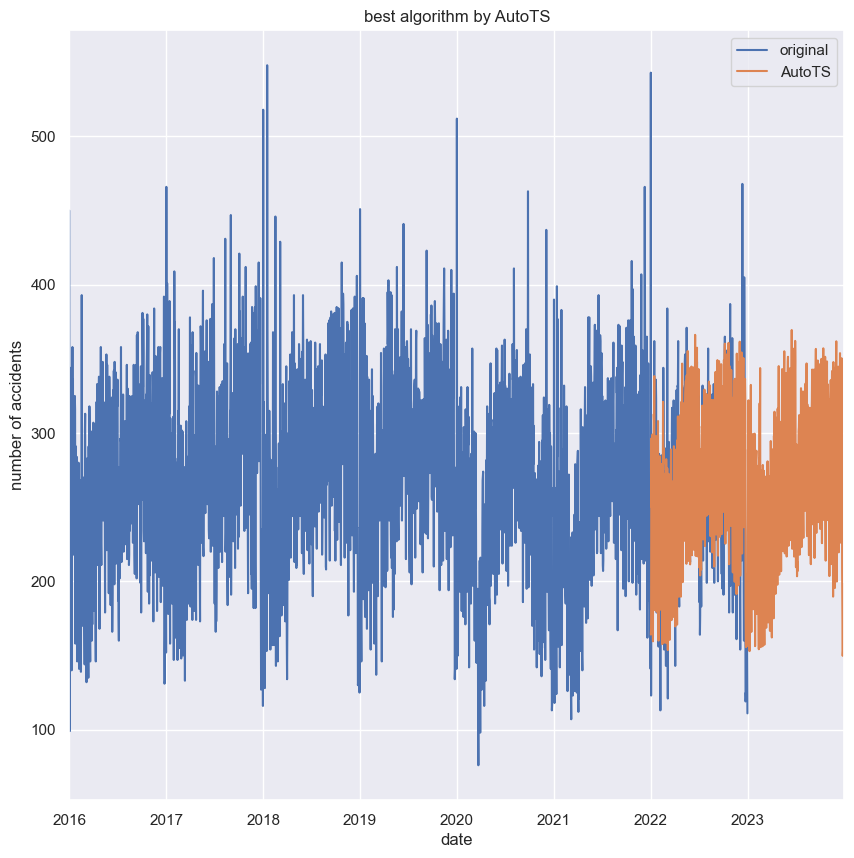

In [120]:
# add results to predict_df
predict_df['AutoTS'] = [np.nan] * len(dataset_train) + list(forecast['predicted'])

# plot the results
predict_df[['original', 'AutoTS']].plot()
plt.title('best algorithm by AutoTS')
plt.xlabel('date')
plt.ylabel('number of accidents')

In [121]:
autots_model.results()

ID               Model  \
0     5e75ed52611fa9266c855f5876eb8720   AverageValueNaive   
1     32c21e08eec3d98d9158c35dfb4410ba   AverageValueNaive   
2     d8bd60351c03557d2b76a1f72be762ff   AverageValueNaive   
3     3c205c901c969cb3f2380ccc43f7a36f  DatepartRegression   
4     68a0c53e76c612a8e64a8b9057930f33  DatepartRegression   
...                                ...                 ...   
1356  0a0a160b35e894ad333bcbc6a217738c            Ensemble   
1357  e48e5b07f1eeb743ae14956a8eda2d08            Ensemble   
1358  e48e5b07f1eeb743ae14956a8eda2d08            Ensemble   
1359  3d1797399d2706a5dc8df5f0ca9095e9            Ensemble   
1360  5c4fde7bc8e276185b2274c3d664ca1d            Ensemble   

                                        ModelParameters  \
0                    {"method": "Mean", "window": null}   
1                    {"method": "Mean", "window": null}   
2                    {"method": "Mean", "window": null}   
3     {"regression_model": {"model": "DecisionTree",...   
4     {"regression_model": {"model": "SVM", "model_p...   
...                                                 ...   
1356  {"model_name": "BestN", "model_count": 5, "mod...   
1357  {"model_name": "Dist", "model_count": 2, "mode...   
1358  {"model_name": "Dist", "model_count": 2, "mode...   
1359  {"model_name": "BestN", "model_count": 3, "mod...   
1360  {"model_name": "BestN", "model_count": 3, "mod...   

                               TransformationParameters  \
0     {"fillna": "fake_date", "transformations": {"0...   
1     {"fillna": "mean", "transformations": {"0": "C...   
2     {"fillna": "rolling_mean_24", "transformations...   
3     {"fillna": "mean", "transformations": {"0": "C...   
4     {"fillna": "zero", "transformations": {"0": "C...   
...                                                 ...   
1356                                                 {}   
1357                                                 {}   
1358                                                 {}   
1359                                                 {}   
1360                                                 {}   

      TransformationRuntime             FitRuntime         PredictRuntime  \
0    0 days 00:00:00.041888 0 days 00:00:00.000997 0 days 00:00:00.002992   
1    0 days 00:00:00.038895 0 days 00:00:00.000996 0 days 00:00:00.001995   
2    0 days 00:00:00.016955 0 days 00:00:00.000997 0 days 00:00:00.000996   
3    0 days 00:00:00.040891        0 days 00:00:00 0 days 00:00:01.096067   
4    0 days 00:00:00.054858        0 days 00:00:00 0 days 00:00:01.112023   
...                     ...                    ...                    ...   
1356        0 days 00:00:00 0 days 00:00:15.763854 0 days 00:00:00.001023   
1357        0 days 00:00:00 0 days 00:00:02.841365        0 days 00:00:00   
1358        0 days 00:00:00 0 days 00:00:02.444502        0 days 00:00:00   
1359        0 days 00:00:00 0 days 00:00:10.862934 0 days 00:00:00.002029   
1360        0 days 00:00:00 0 days 00:00:10.644515 0 days 00:00:00.005983   

               TotalRuntime  Ensemble Exceptions  ...  contour_weighted  \
0    0 days 00:00:00.063829         0        NaN  ...          0.695890   
1    0 days 00:00:00.061835         0        NaN  ...          0.528767   
2    0 days 00:00:00.039893         0        NaN  ...          0.745205   
3    0 days 00:00:01.167875         0        NaN  ...          0.542466   
4    0 days 00:00:01.335429         0        NaN  ...          0.471233   
...                     ...       ...        ...  ...               ...   
1356 0 days 00:00:15.791741         1        NaN  ...          0.761644   
1357 0 days 00:00:02.866331         1        NaN  ...          0.753425   
1358 0 days 00:00:02.457287         1        NaN  ...          0.753425   
1359 0 days 00:00:10.885899         1        NaN  ...          0.753425   
1360 0 days 00:00:10.682414         1        NaN  ...          0.753425   

      maxe_weighted  oda_weighted dwae_weighted

In [122]:
from sklearn.metrics import mean_squared_error

target_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)['original'].values
rmse_results = {}

for col in predict_df.columns:
    if col not in ['original', 'temp']:
        # Get the predicted values for the current model
        predicted_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)[col].values

        # Calculate the mean squared error
        mse = mean_squared_error(target_values, predicted_values)

        # Calculate the RMSE by taking the square root of the MSE
        rmse = np.sqrt(mse)

        # Store the RMSE value in the dictionary
        rmse_results[col] = rmse
        
# Convert the dictionary to a DataFrame for easier visualization
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
rmse_df.sort_values(by='RMSE')

RMSE
AutoTS                      40.723743
prophet                     51.463927
GNN                         55.354938
random forest + grid        55.813691
random forest + GA          56.911116
random forest + randomized  56.999480
lstm                        59.288230
transformer                 62.404008
rnn                         62.925377
catboost                    67.423872
svr                         68.188995
arima                       68.675990
xgboost                     69.415562
MLP + GA                    74.593396
MLP + randomized            74.593396
MLP + grid                  74.593396

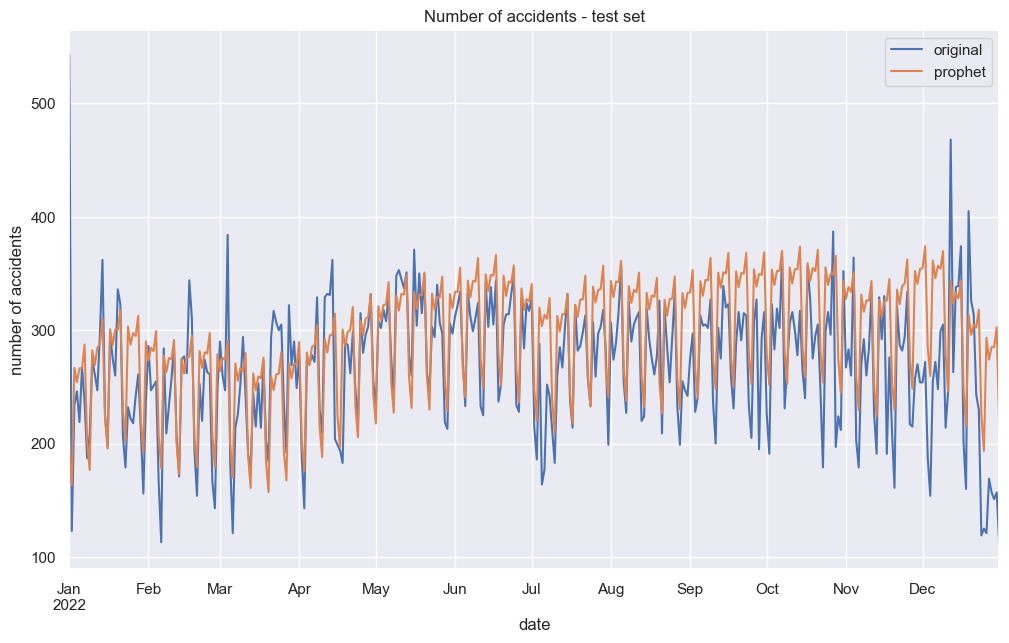

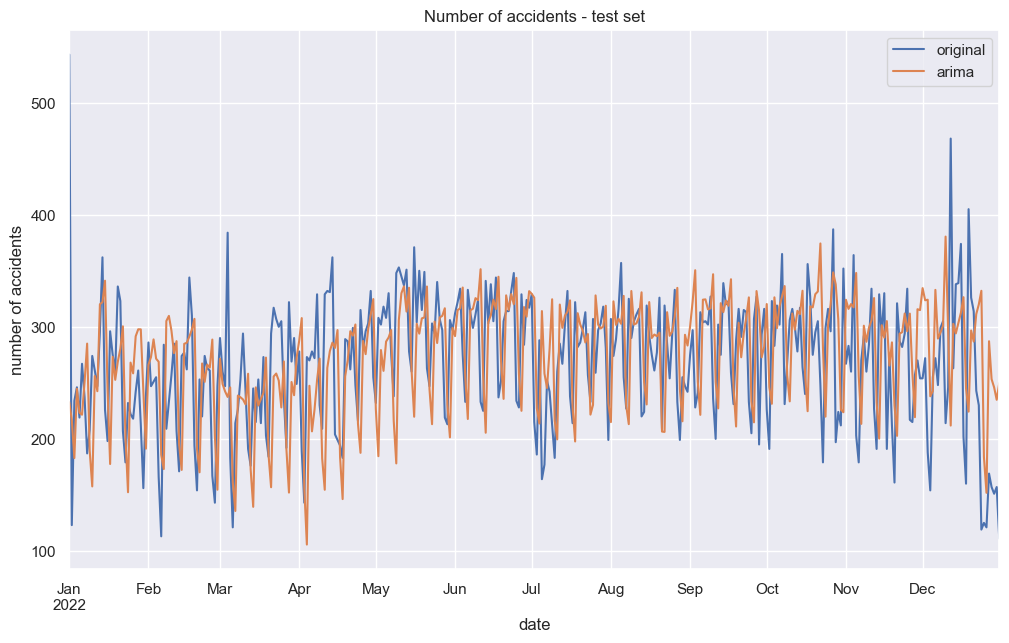

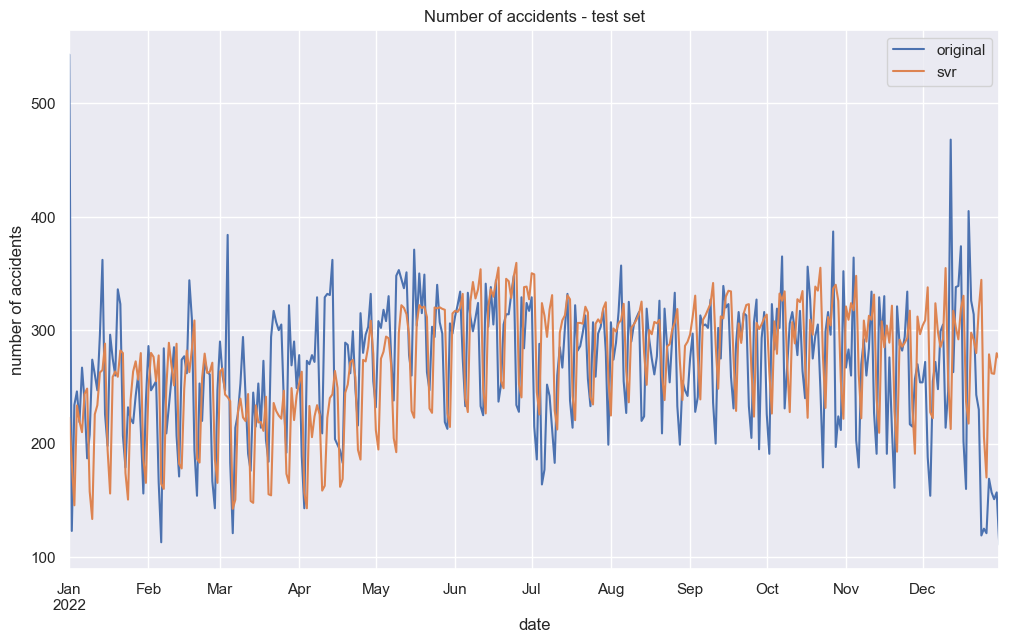

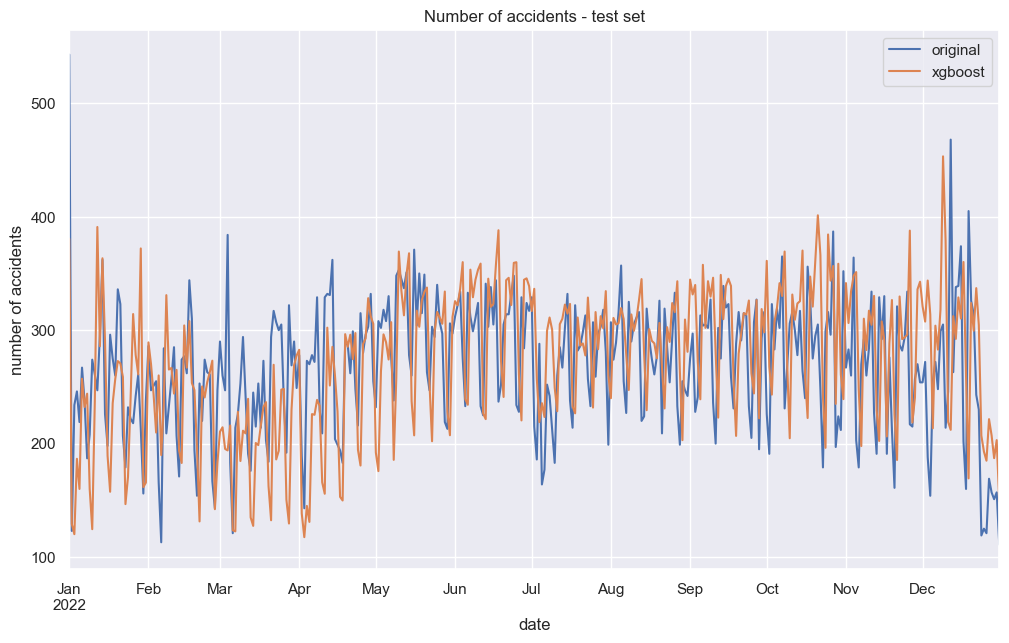

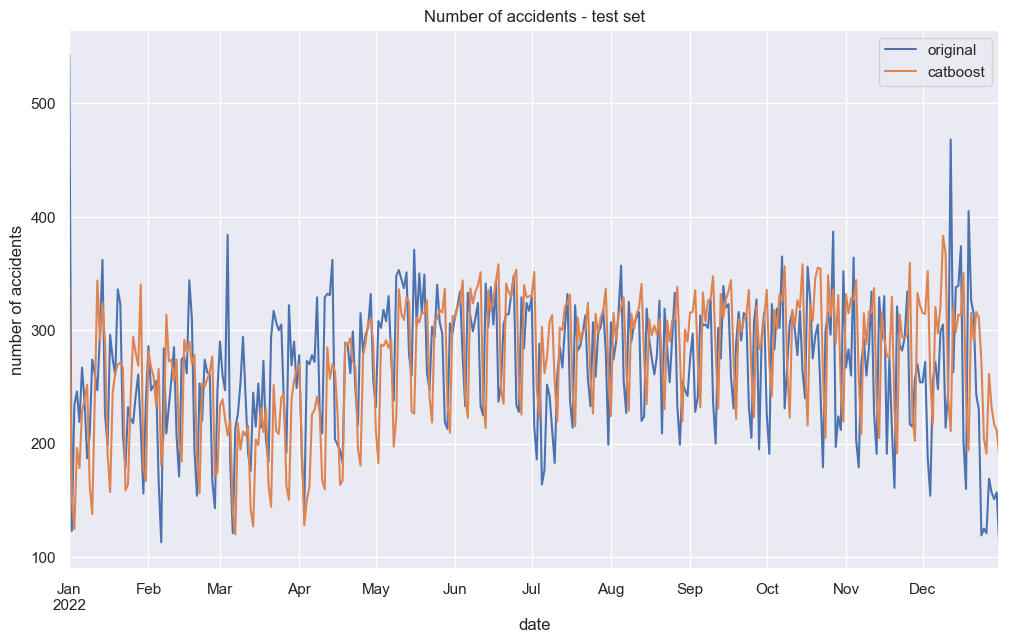

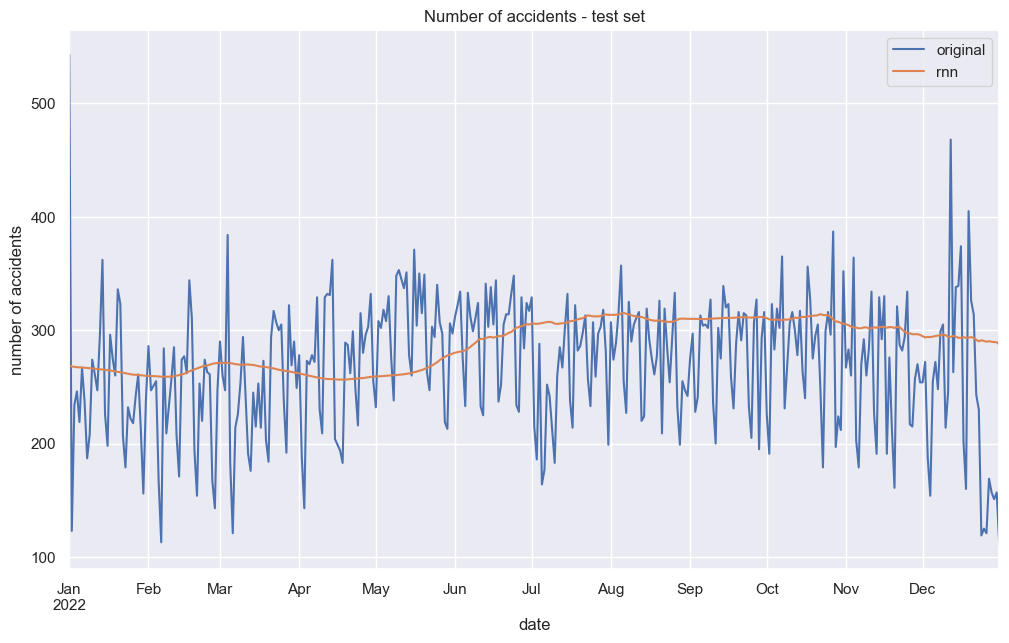

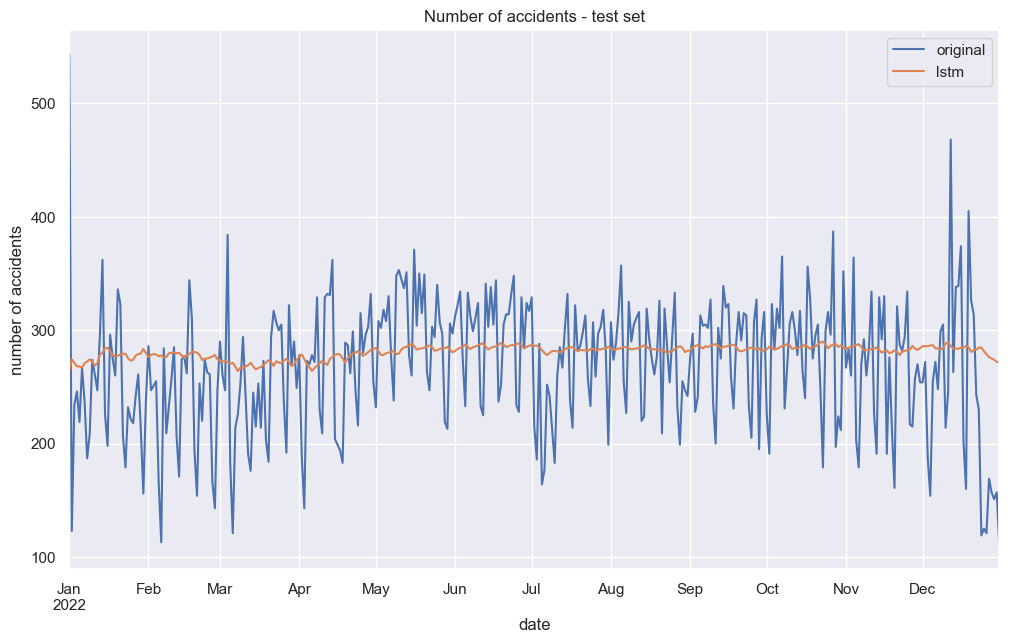

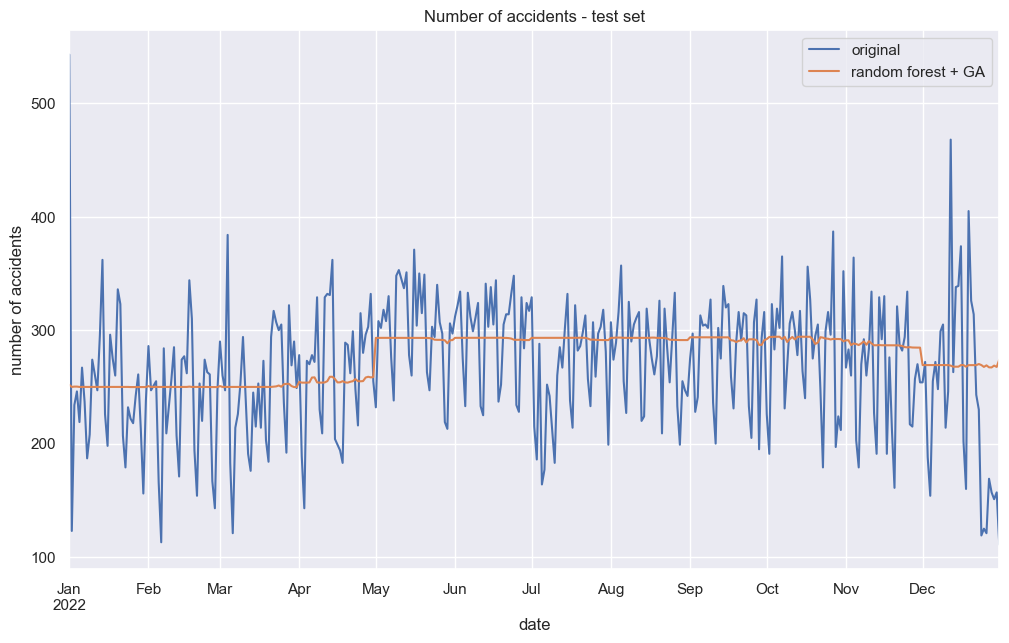

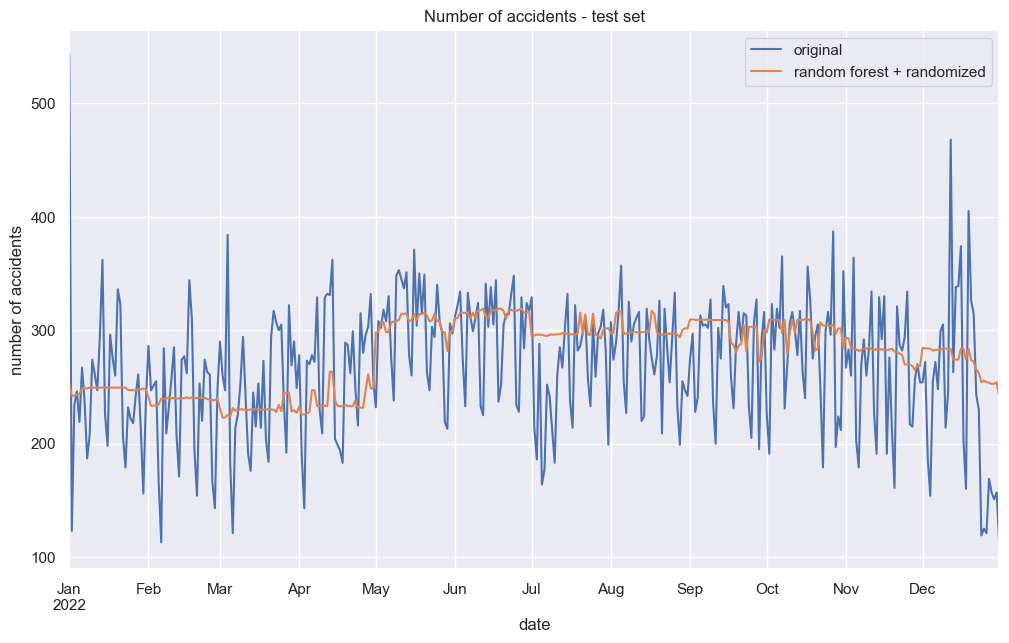

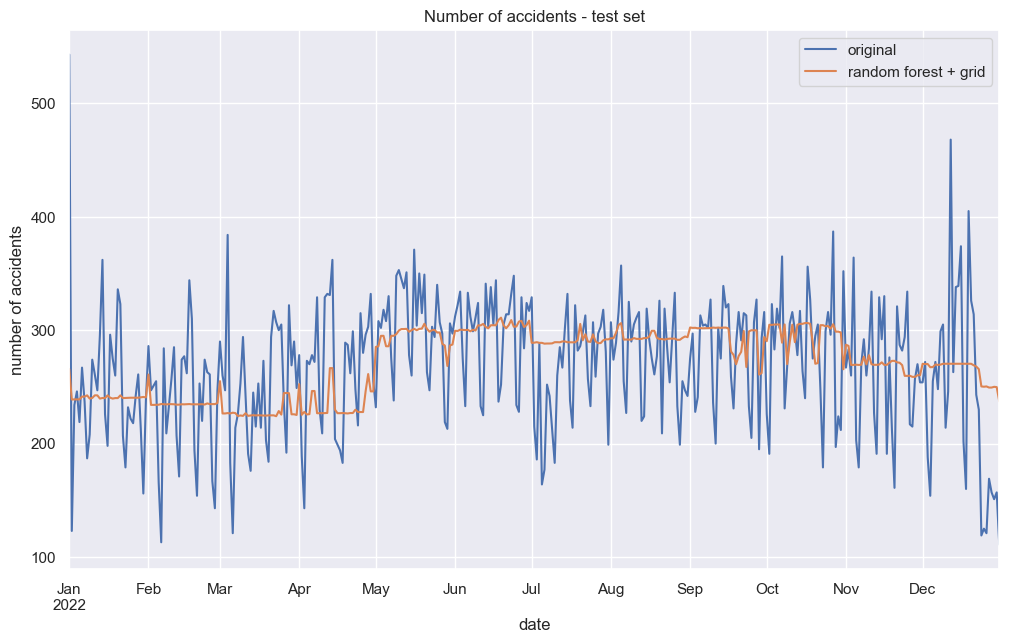

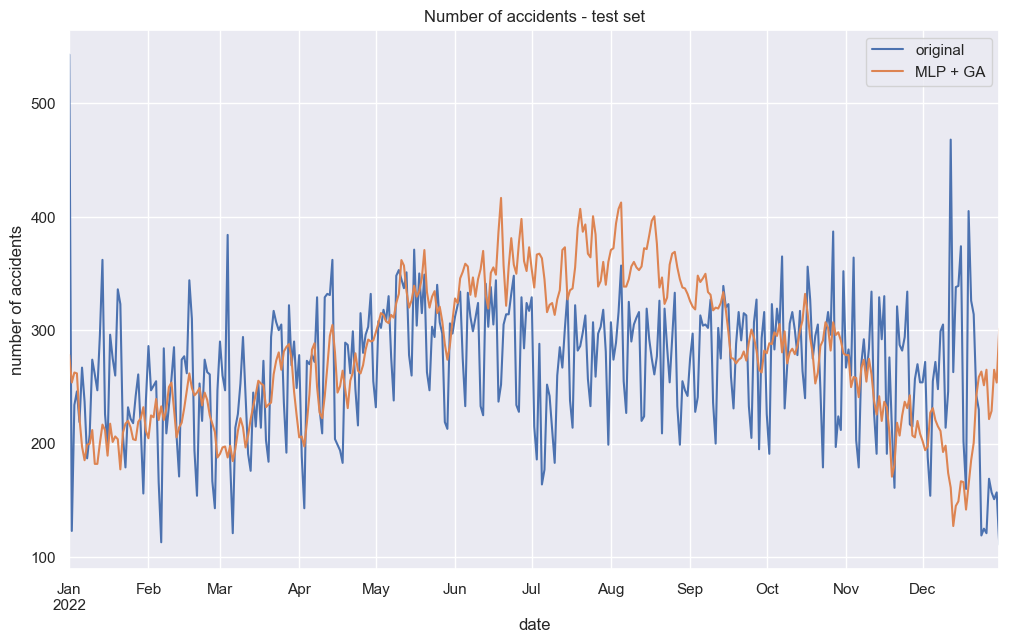

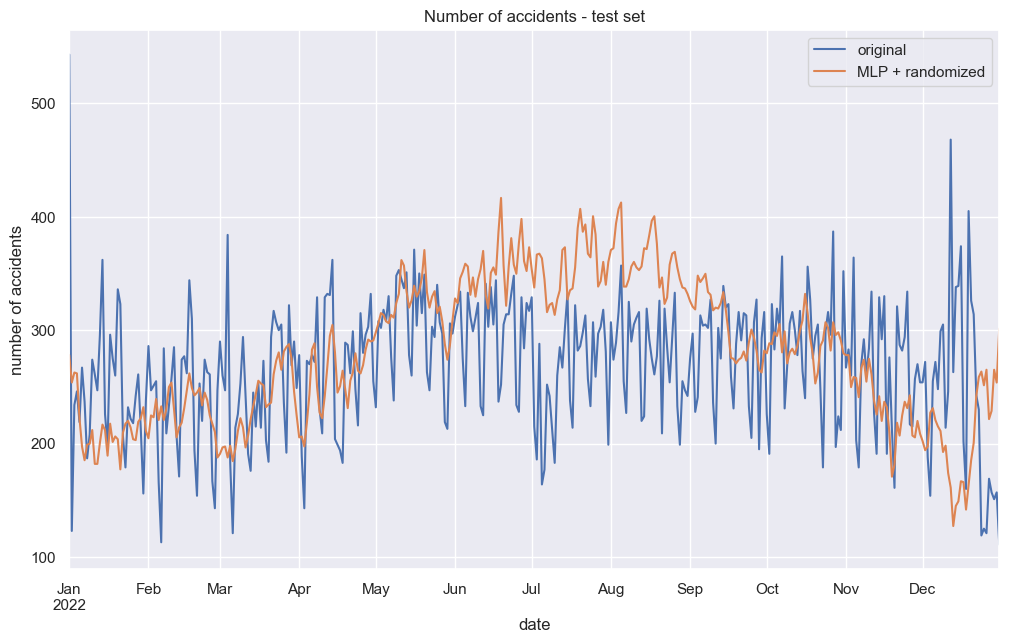

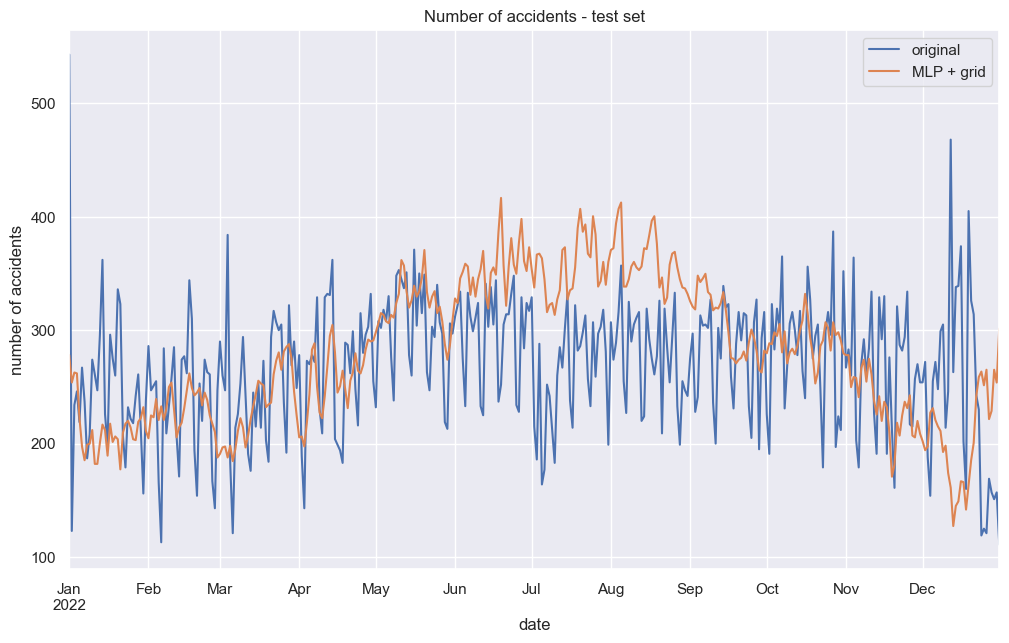

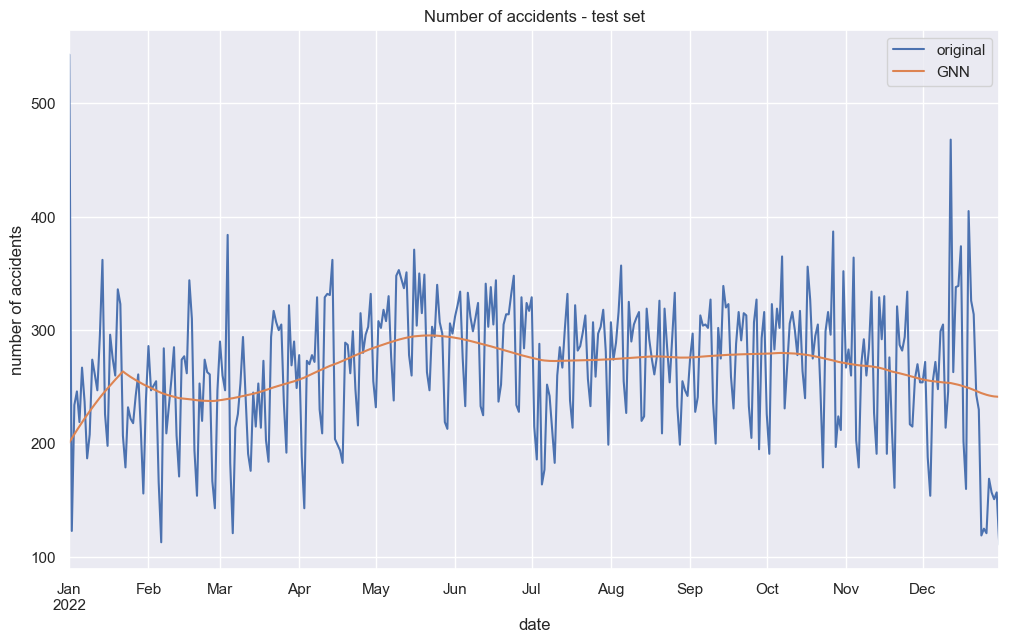

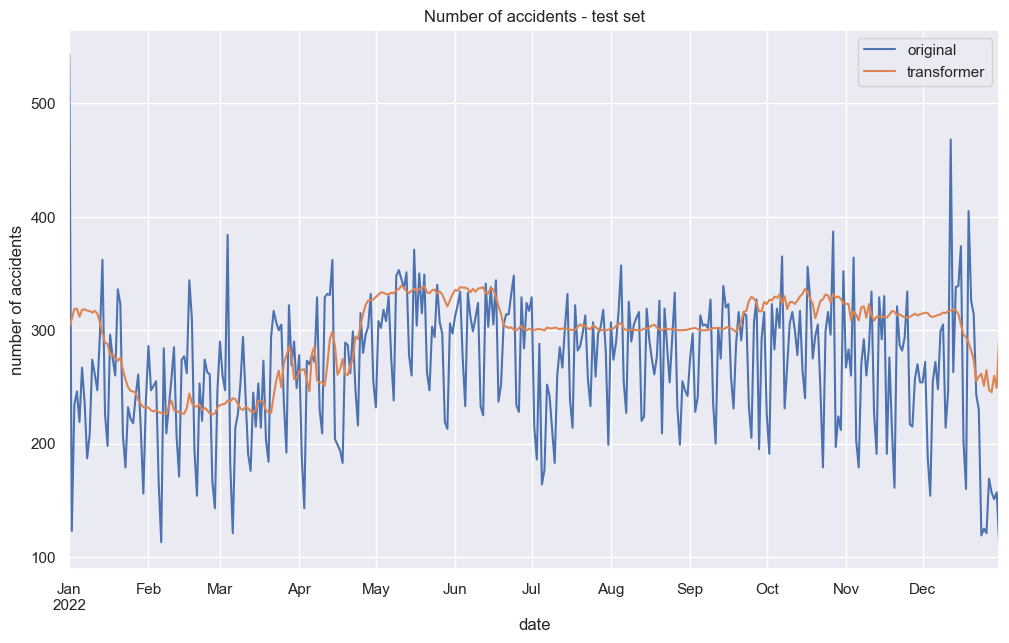

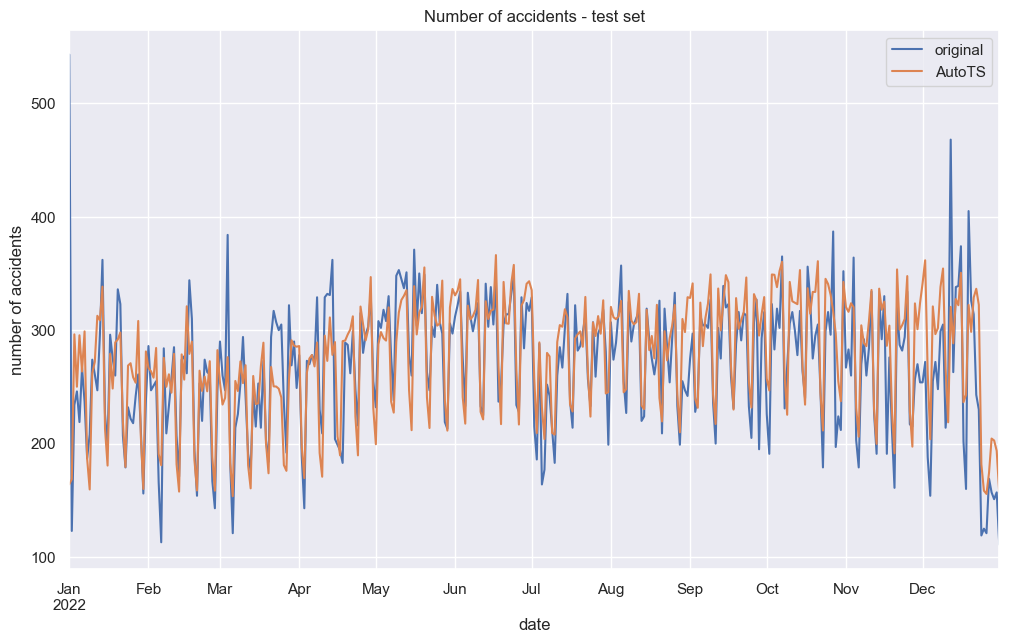

In [123]:
for col in predict_df.columns:
    if col not in ['original', 'temp']:
        plt.rcParams['figure.figsize'] = [12, 7]
        predict_df[['original', col]].tail(periods_to_predict + periods_to_predict).head(periods_to_predict).plot()
        plt.title('Number of accidents - test set')
        plt.xlabel('date')
        plt.ylabel('number of accidents')
        plt.show()

Text(0.5, 1.0, '')

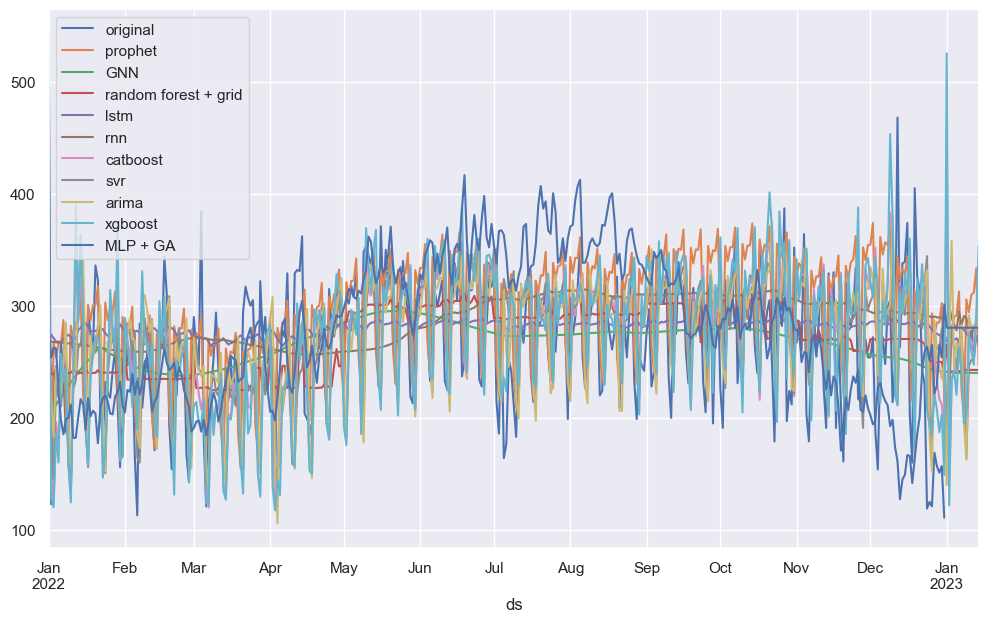

In [124]:
predict_df[['original', 'prophet', 'GNN', 'random forest + grid', 'lstm', 'rnn', 
            'catboost', 'svr', 'arima', 'xgboost', 'MLP + GA']].tail(
    periods_to_predict + periods_to_predict).head(periods_to_predict + min(14, periods_to_predict)).plot()
plt.title('')